# ATom-1 (07/29/16 - 08/23/16)

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker
from netCDF4 import Dataset
from os import listdir
import pandas as pd
import datetime
import collections
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Polygon
from matplotlib.offsetbox import AnchoredText
from sklearn import linear_model
from random import randint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24})

### Retrieve data, add date variable, list all variables

In [2]:
files = listdir('Data/post-QA/')
frames = [pd.read_csv('Data/post-QA/' + f) for f in files]
atom = pd.concat(frames, keys=(f[10:18] for f in files))
atom['date'] = atom.index.get_level_values(0)
del atom['Latitude']
del atom['Longitude']

# this chunk of code for first fig colorbar
orddats = []
strdats = []
atom['dateidx'] = atom.index.get_level_values(0) 
dats = list(set(atom['date']))
for f in dats:
    orddats.append(int(f))
orddats.sort()
for f in orddats:
    strdats.append(str(f))
ytks = [None] * len(strdats)
for i, dt in list(enumerate(strdats)):
    idx = atom['dateidx']==dt
    atom['dateidx'][idx] = i
    ytks[i] = dt[-4:-2] + '-' + dt[-2:] + '-' + dt[0:4]

atom = atom.sort_values('UTC_Start');

In [14]:
list(atom)

['2_Methylpentane_TOGA',
 '3_Methylpentane_TOGA',
 'AMS_MidPointTime',
 'AMS_Stoptime',
 'APO_AO2',
 'ARML2dr.DOSE',
 'ARML3dr.DOSE',
 'Acetaldehyde_TOGA',
 'Acetone_TOGA',
 'Acrolein_TOGA',
 'Aircraft_Sun_Azimuth',
 'Aircraft_Sun_Elevation',
 'AlkaliSaltFrac_PALMS',
 'Alpha_Pinene_TOGA',
 'AmmBalance_lt_1um_AMS',
 'Ammonium_lt_1um_AMS',
 'Ammonium_lt_1um_AMS_DL',
 'Ammonium_lt_1um_AMS_prec',
 'BC_mass_90_550_nm',
 'Benzene_TOGA',
 'Beta_Pinene_TOGA',
 'BioBurnFrac_PALMS',
 'Bromodichloromethane_TOGA',
 'Bromoform_TOGA',
 'Bromoiodomethane_TOGA',
 'Butanal_TOGA',
 'C3H8_TOGA',
 'CAS_Nacc',
 'CAS_Ncoa1',
 'CAS_Ncoa2',
 'CAS_Ncoa3',
 'CAS_Ntot',
 'CFC113_TOGA',
 'CFC11_TOGA',
 'CH2O_TOGA',
 'CH3CN_TOGA',
 'CH4_GCECD',
 'CH4_NOAA',
 'CH4_QCLS',
 'CH4_UCATS',
 'CH4e_GCECD',
 'CH4e_UCATS',
 'CO2_AO2',
 'CO2_NOAA',
 'CO2_QCLS',
 'CO_GCECD',
 'CO_NOAA',
 'CO_QCLS',
 'CO_UCATS',
 'COe_GCECD',
 'COe_UCATS',
 'Cabin_Pressure',
 'Chloride_lt_1um_AMS',
 'Chloride_lt_1um_AMS_DL',
 'Chloride_lt_1um_

### "Remote" region delineations

In [3]:
# 20160803, North Pacific, CH2O/CH4 oxid. corr
bxt1 = [20., 60.]
bxn1 = [-175., -150.]

# 20160806, Central Pacific, CH2O/CH4 oxid. corr
bxt2 = [-10., 15.]
bxn2 = [-180., -160.]

# 20160808, Southern Ocean, Both
bxt3 = [-45., -15.]
bxn3 = [-180., -160.]

# 20160817, Equatorial Atlantic, Nat/anth emiss
bxt4 = [-40., -10.]
bxn4 = [-30., -10.]

# 20160820, North Atlantic, CH2O/CH4 oxid. corr
bxt5 = [40., 60.]
bxn5 = [-50., -20.]

# Mid-Pacific
bxt6 = [0., 25.]
bxn6 = [-130., -110.]

### Useful functions for this dataset (drop or mask missing values, = -99999.0)

In [4]:
def dropfill(df, var):
    a = df[var]<-99998.0
    newdf = df.drop(df.index[a])
#    b = newdf[var]<-10.
#    nwwdf = newdf.drop(newdf.index[b])
    return newdf;

In [5]:
def mask(df, var):
    nvar = np.ma.masked_invalid(df[var])
    return nvar;

# Map Flight Tracks

In [6]:
def draw_screen_poly( lats, lons, m, col):
    mlons = [lons[0], lons[0], lons[1], lons[1]]
    mlats = [lats[0], lats[1], lats[1], lats[0]]
    x, y = m( mlons, mlats )
    xy = zip(x,y)
    poly = Polygon( xy, facecolor=col, alpha=0.4 )
    plt.gca().add_patch(poly)

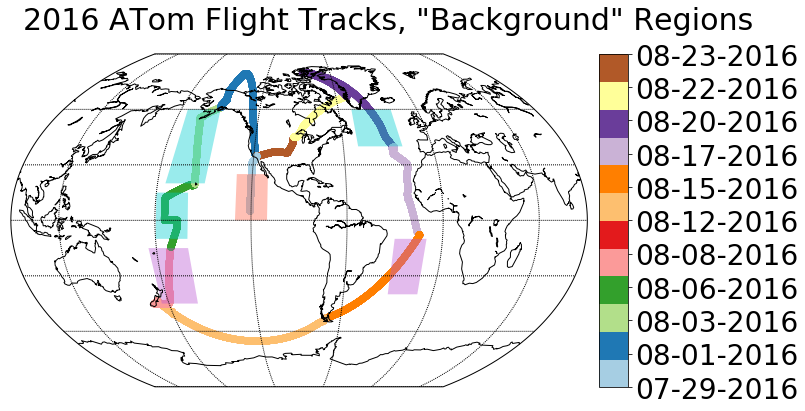

In [14]:
bxn3 = [175., -160.]
fig = plt.figure(figsize=[12,6])
fig.add_subplot(111)
m = Basemap(projection='kav7', lon_0=-90., resolution='c')
m.drawcoastlines()
m.drawmeridians(np.arange(-180., 180., 60.))
m.drawparallels(np.arange(-90., 99., 30.))

lats = mask(atom, 'G_LAT')
lons = mask(atom, 'G_LONG')
x, y = m(lons, lats)

locs = m.scatter(x, y, c=atom['dateidx'], cmap='Paired')
cbar = m.colorbar(locs, ticks=np.arange(0, 11))
cbar.ax.set_yticklabels(ytks, fontsize=28)

draw_screen_poly(bxt1, bxn1, m, col='darkturquoise')
draw_screen_poly(bxt2, bxn2, m, col='darkturquoise')
draw_screen_poly(bxt3, bxn3, m, col='mediumorchid')
draw_screen_poly(bxt4, bxn4, m, col='mediumorchid')
draw_screen_poly(bxt5, bxn5, m, col='darkturquoise')
draw_screen_poly(bxt6, bxn6, m, col='tomato')

plt.suptitle('2016 ATom Flight Tracks, "Background" Regions', fontsize=30)
plt.savefig('ATom_flighttracks.jpg')
plt.tight_layout()
plt.subplots_adjust(top=0.87)

bxn3 = [-180., -160.]

In the plot above, green patches indicate regions where $CH_2O$ is highly correlated with k[$CH_4$][OH]; red indicates regions where the GC simulation with anthropogenic emissions off differs most significantly from base; blue is an intersection of the preceding two conditions.

The map above is motivated by work by Luke Valin:

<img src="files/luke_corr.png">

# Compare between regions

Apparently robust findings:

    CH4/HCHO relationship good predictor of OH in lower troposphere in absense of oxidized N
    high NOy, low CH4, and some photolysis are conditions for high OH in upper troposphere
    high NOy and high CH4 indicate to low OH
    low photolysis or low NOy indicate to production of HO2 instead of OH
    CH4/log(CO) generally linear unless low sunlight -> production of HCHO
    log(H2O)/log(HCHO) linear, affected by photolysis and NOy
    

In [7]:
rg_ttl_loc = collections.OrderedDict()
rg_ttl_loc['N. Pacific \n(HCHO/[CH4][OH])'] = [bxt1[:], bxn1[:]]
rg_ttl_loc['Cent. Pacific \n(Both conditions)'] = [bxt2[:], bxn2[:]]
rg_ttl_loc['Southern Ocean \n(Both conditions)'] = [bxt3[:], bxn3[:]]
rg_ttl_loc['Equat. Atlantic \n(High nat/total)'] = [bxt4[:], bxn4[:]]
rg_ttl_loc['N. Atlantic \n(HCHO/[CH4][OH])'] = [bxt5[:], bxn5[:]]
rg_ttl_loc['East Pacific \n(High nat/total)'] = [bxt6[:], bxn6[:]]

In [8]:
reg_leg = {'N. Pacific \n(HCHO/[CH4][OH])': 'N Pac',
    'Cent. Pacific \n(Both conditions)': 'C Pac',
    'Southern Ocean \n(Both conditions)': 'S Ocn',
    'Equat. Atlantic \n(High nat/total)': 'Eq Atl',
    'N. Atlantic \n(HCHO/[CH4][OH])': 'N Atl',
    'East Pacific \n(High nat/total)': 'E Pac'}

In [9]:
reg_cv = {'HCHO': ['HCHO'], 'NOx': ['NO_CL','NO2_CL'], 'NOy': ['NOy_CL'], r'$CH_4$ anom.': ['CH4_NOAA'],
          'CO:NOx': ['NO_CL', 'NO2_CL', 'CO_NOAA'], r'$H_2O$': ['H2O_ppmv'], 
          'JO(1D)': ['j[O3->O2+O(1D)]'], 'OH': ['OH_pptv', 'Solar_Zenith_Angle'], 'NOx:NOy': ['NO_CL', 'NO2_CL', 'NOy_CL'],
          r'$O_3$': ['O3_CL'], 'CO': ['CO_NOAA'], r'$CH_4$': ['CH4_NOAA'],
          r'$HNO_3$': ['HNO3_CIT'], r'$HO_2$': ['HO2_pptv'], 'NO': ['NO_CL'],
          r'$NO_2$': ['NO_CL'], 'NOy:NOx': ['NO_CL', 'NO2_CL', 'NOy_CL'],
          r'$H_2O_2$': ['H2O2_CIT'], 'HOx': ['OH_pptv', 'HO2_pptv'], 'Temp.': ['T'],
          'CO:NOy': ['CO_NOAA', 'NOy_CL'], r'$CH_4:NOy$': ['CH4_NOAA', 'NOy_CL'],
          'k[$CH_4$][OH]': ['CH4_NOAA', 'OH_pptv', 'T', 'P']}
units = {'HCHO': '(pptv)', 'NOx': '(ppbv)', 'NOy': '(ppbv)', r'$CH_4$ anom.': '(ppbv)',
         'CO:NOx': '(unitless)', r'$H_2O$': '(ppthv)', 'JO(1D)': '(/s)', 
         'OH': '(pptv)', 'NOx:NOy': '(unitless)', r'$O_3$': '(ppbv)', r'$O_3$': '(ppbv)',
         'CO': '(ppbv)', r'$CH_4$': '(ppbv)', r'$HNO_3$': '(ppbv)', r'$HO_2$': '(pptv)',
         'NO': '(ppbv)', r'$NO_2$': '(ppbv)', 'NOy:NOx': '(unitless)', r'$H_2O_2$': '(pptv)',
         'HOx': '(pptv)', 'CO:NOy': '(unitless)', r'$CH_4:NOy$': '(unitless)', 'Temp.': ' (C)',
         'k[$CH_4$][OH]': ' (ppb/d)'}
rate = {'k[$CH_4$][OH]': 1.85e-20} # cm^3/molec/s

# Correlation plots

## Compare between regions a relationship between two compounds, colored by a third

In [10]:
def reject_outliers(data, var, m=2):
    return var[abs(data - np.mean(data)) < m * np.std(data)]

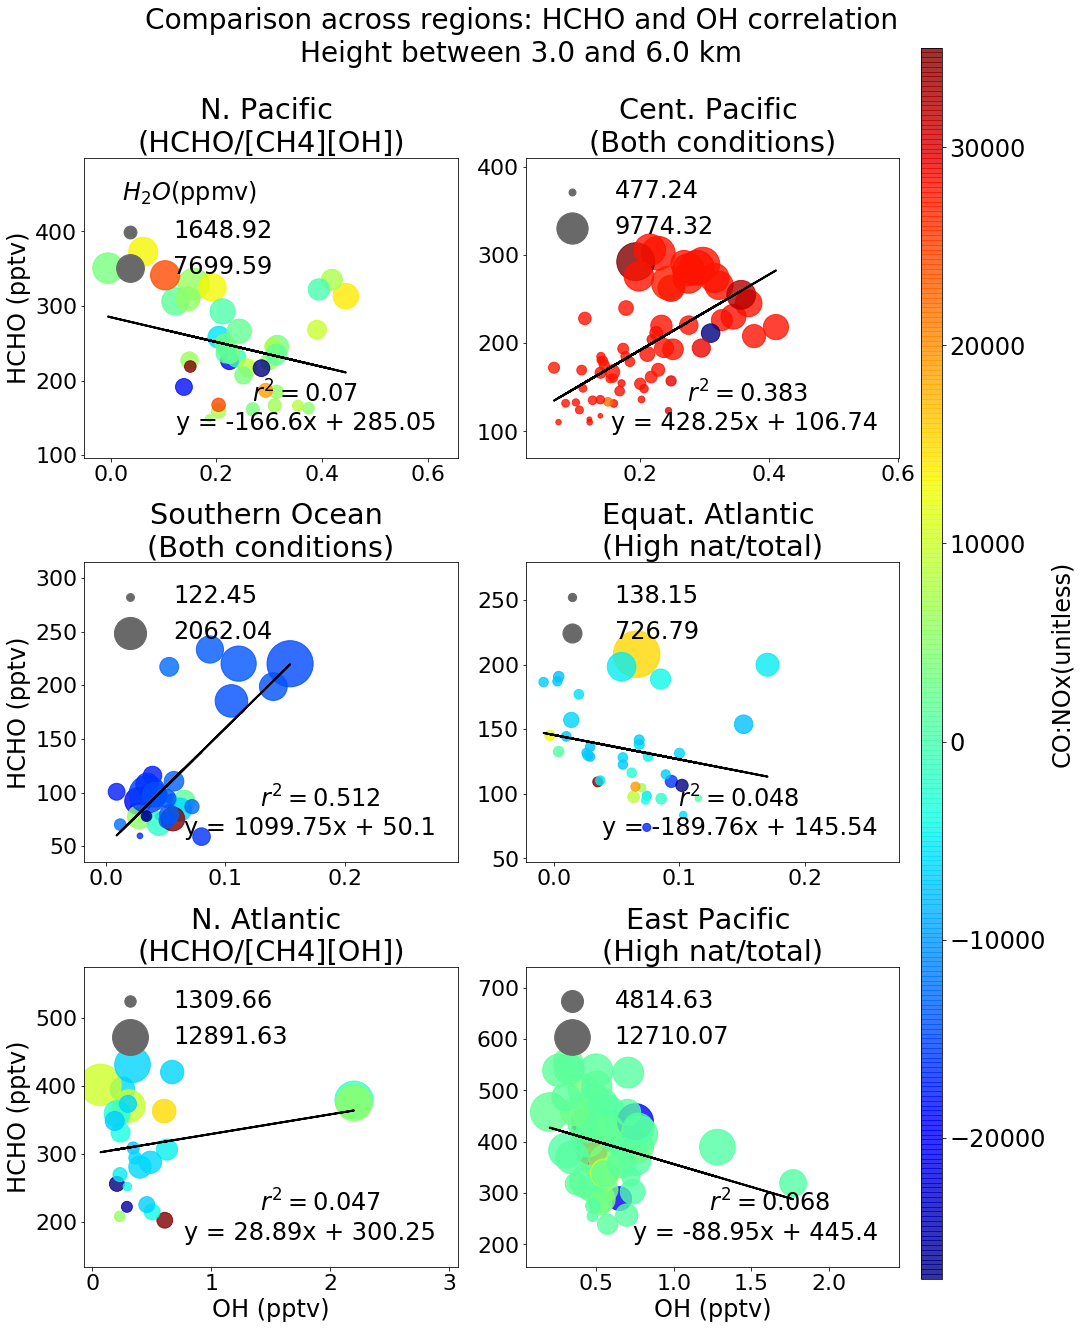

In [15]:
cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'OH', 'CO:NOx', r'$H_2O$')
plt.savefig('hcho_oh_lin_highp_conox_h2o.jpg')

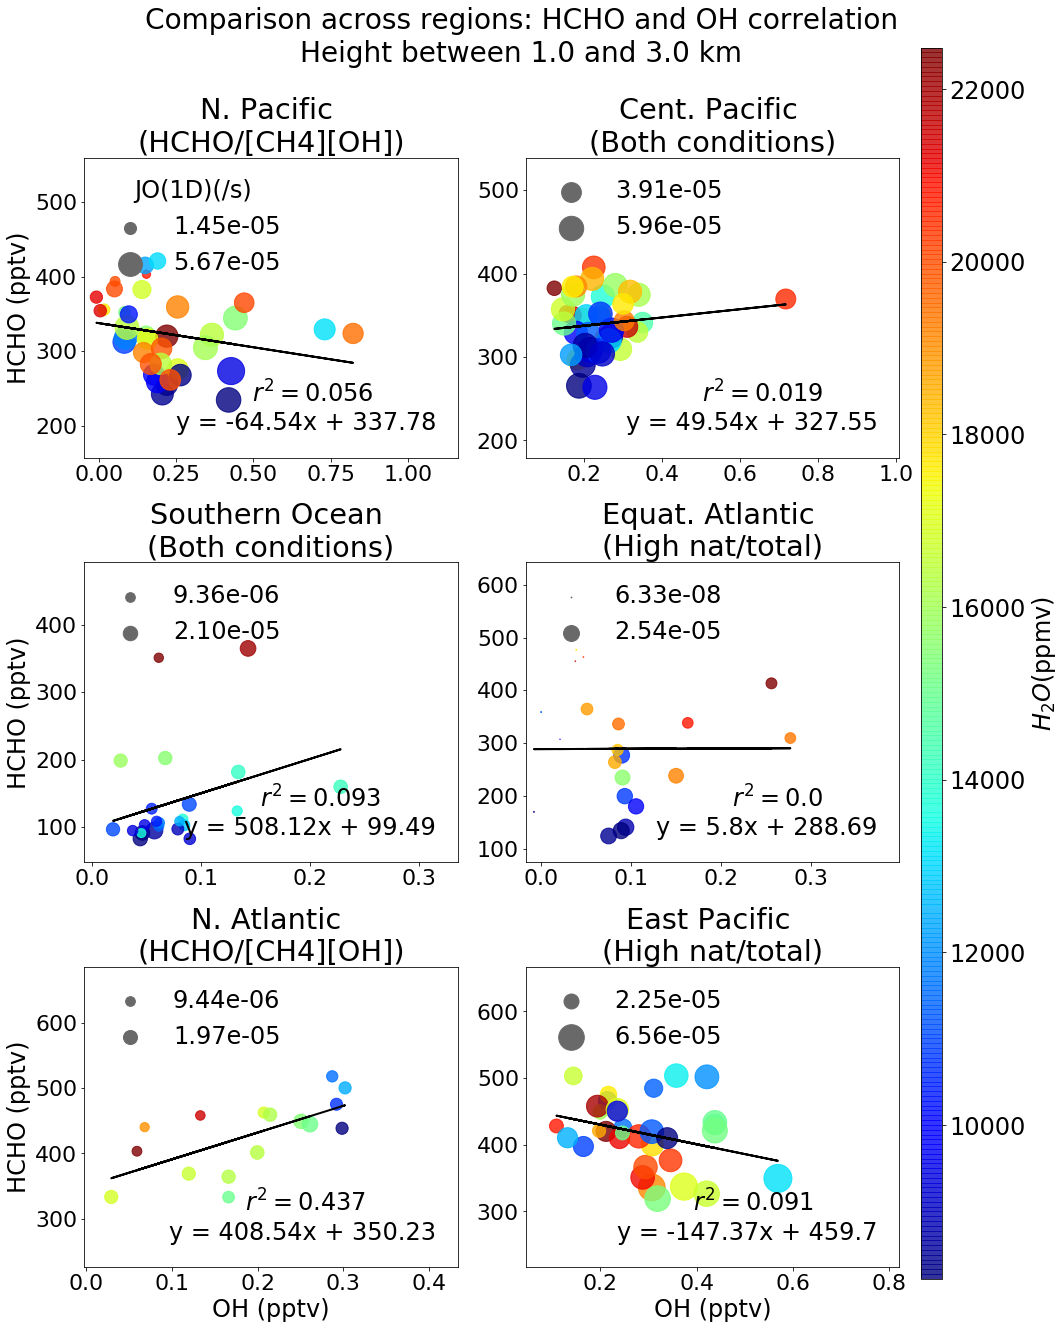

In [16]:
cor_reg_ht(rg_ttl_loc, 1e3, 3e3, 'HCHO', 'OH', r'$H_2O$', 'JO(1D)')
plt.savefig('hcho_oh_lin_lowp_h2o_jo1d.jpg')

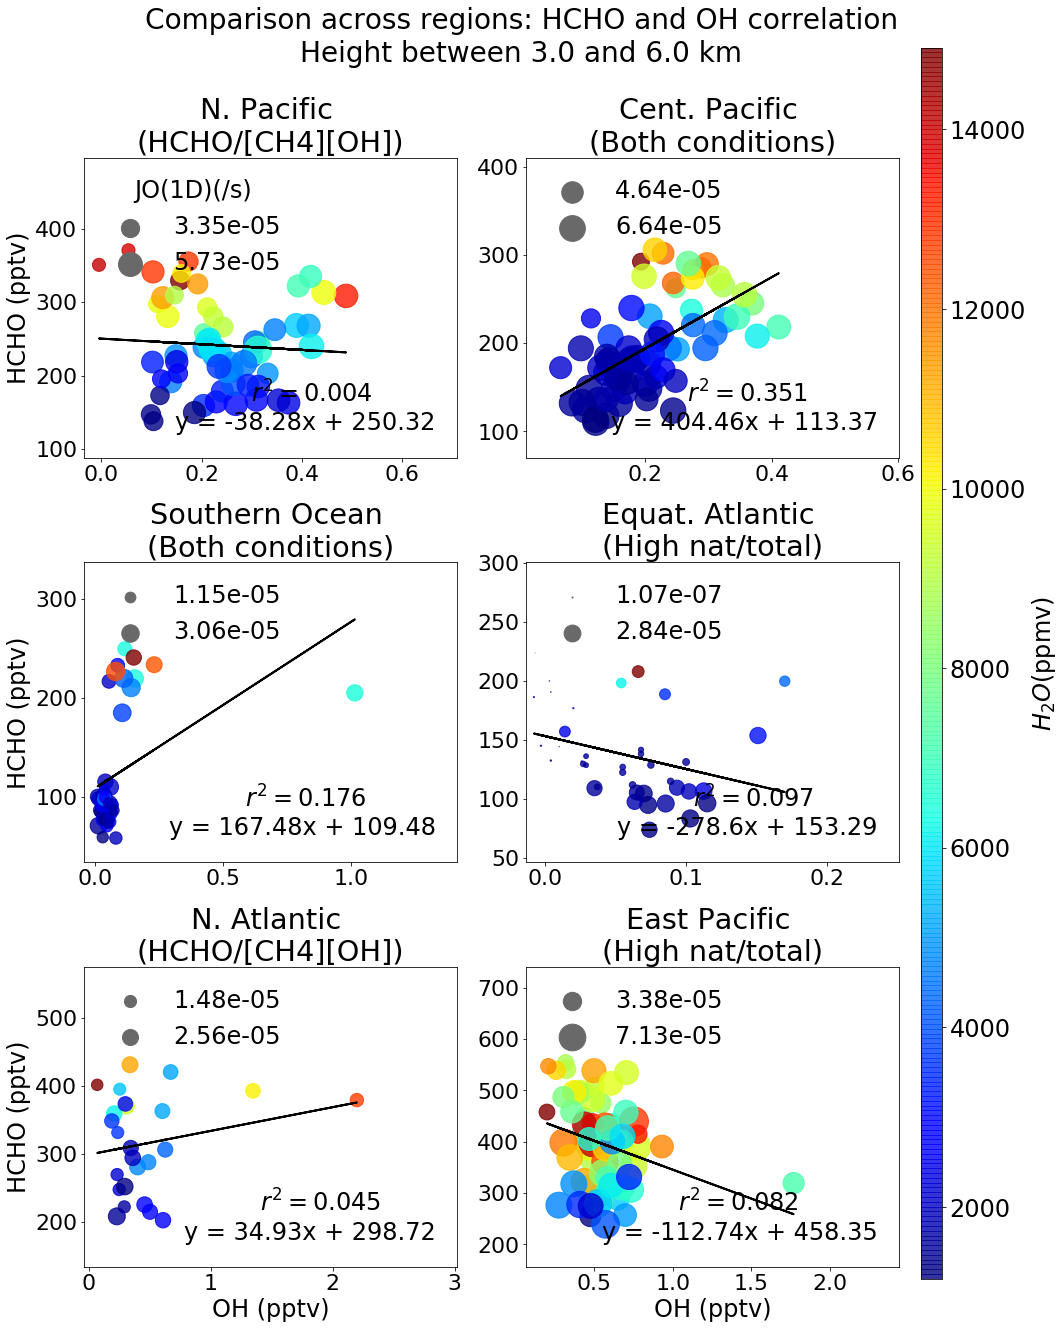

In [17]:
cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'OH', r'$H_2O$', 'JO(1D)')
plt.savefig('hcho_oh_lin_highp_h2o_jo1d.jpg')

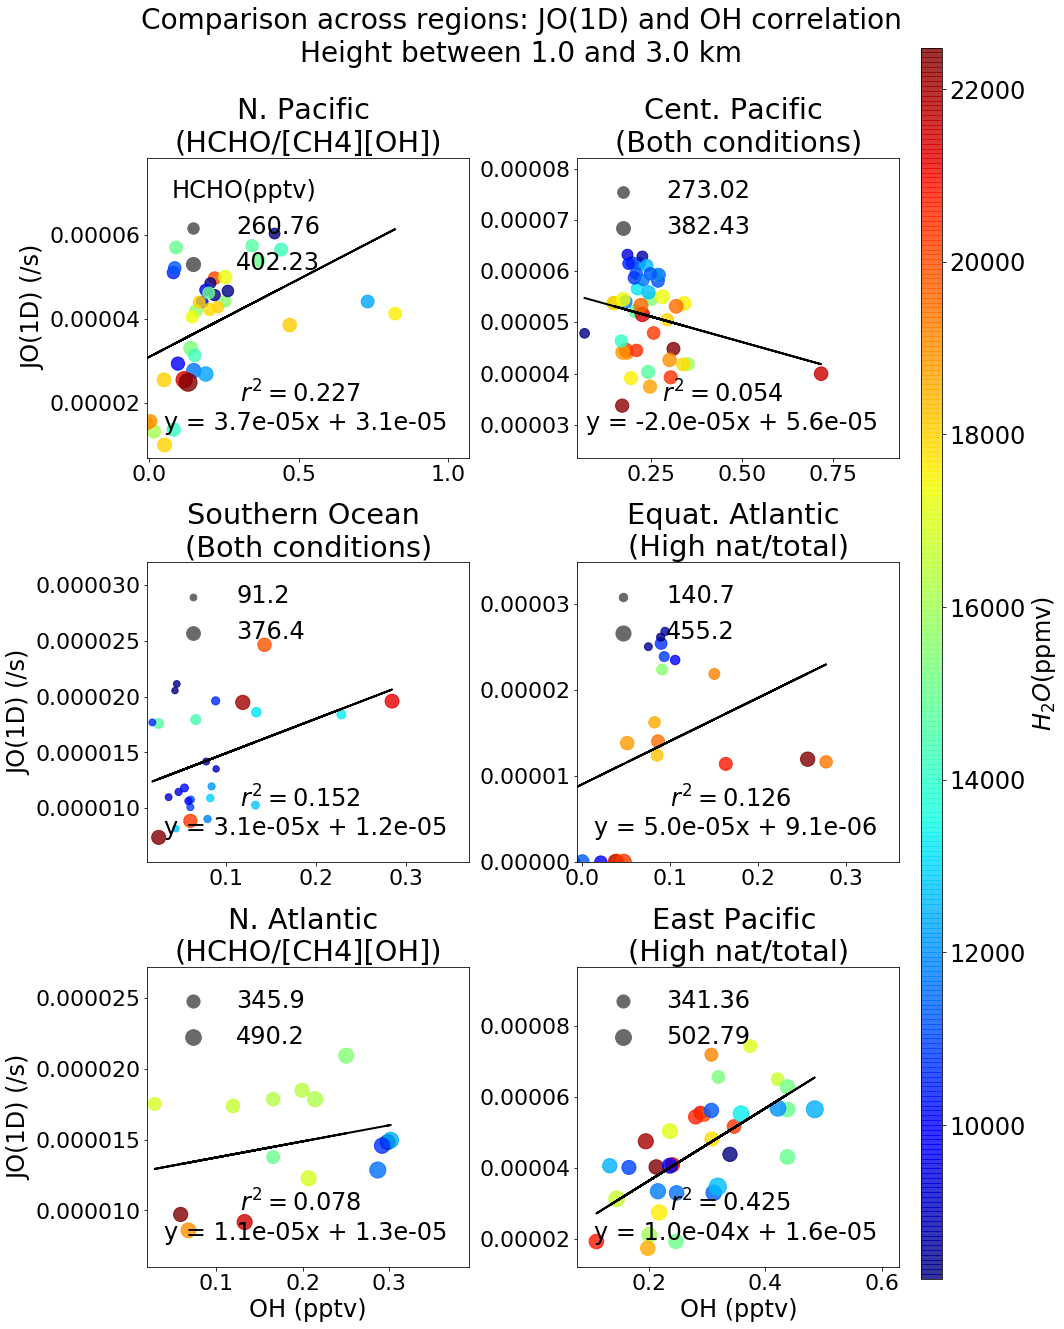

In [18]:
cor_reg_ht(rg_ttl_loc, 1e3, 3e3, 'JO(1D)', 'OH', r'$H_2O$', 'HCHO')
plt.savefig('jo1d_oh_lin_lowp_h2o_hcho.jpg')

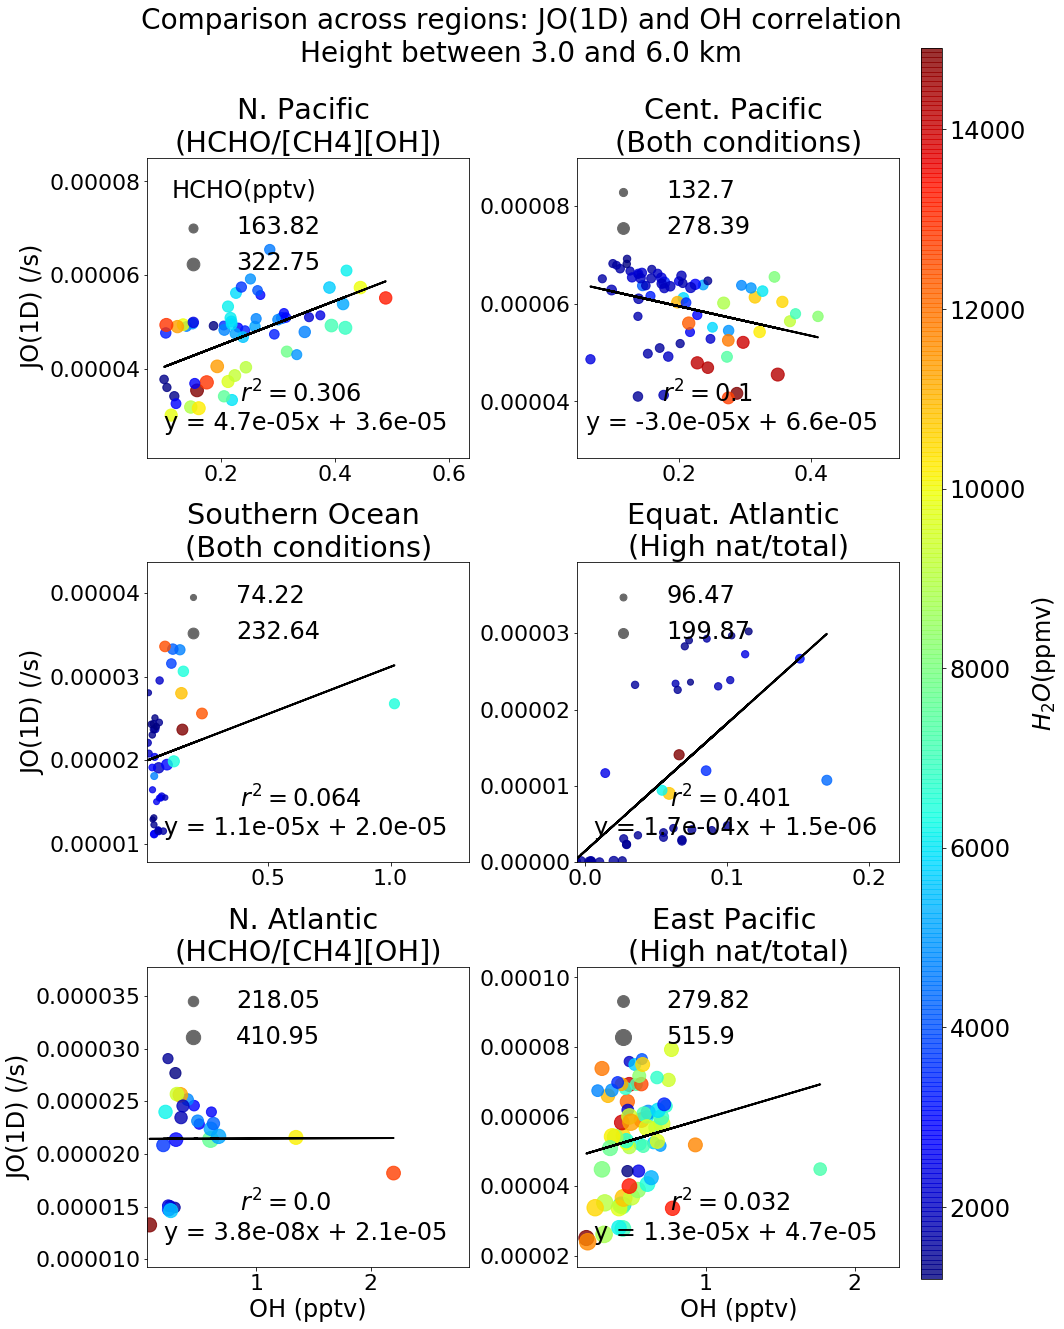

In [19]:
cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'JO(1D)', 'OH', r'$H_2O$', 'HCHO')
plt.savefig('jo1d_oh_lin_highp_h2o_hcho.jpg')

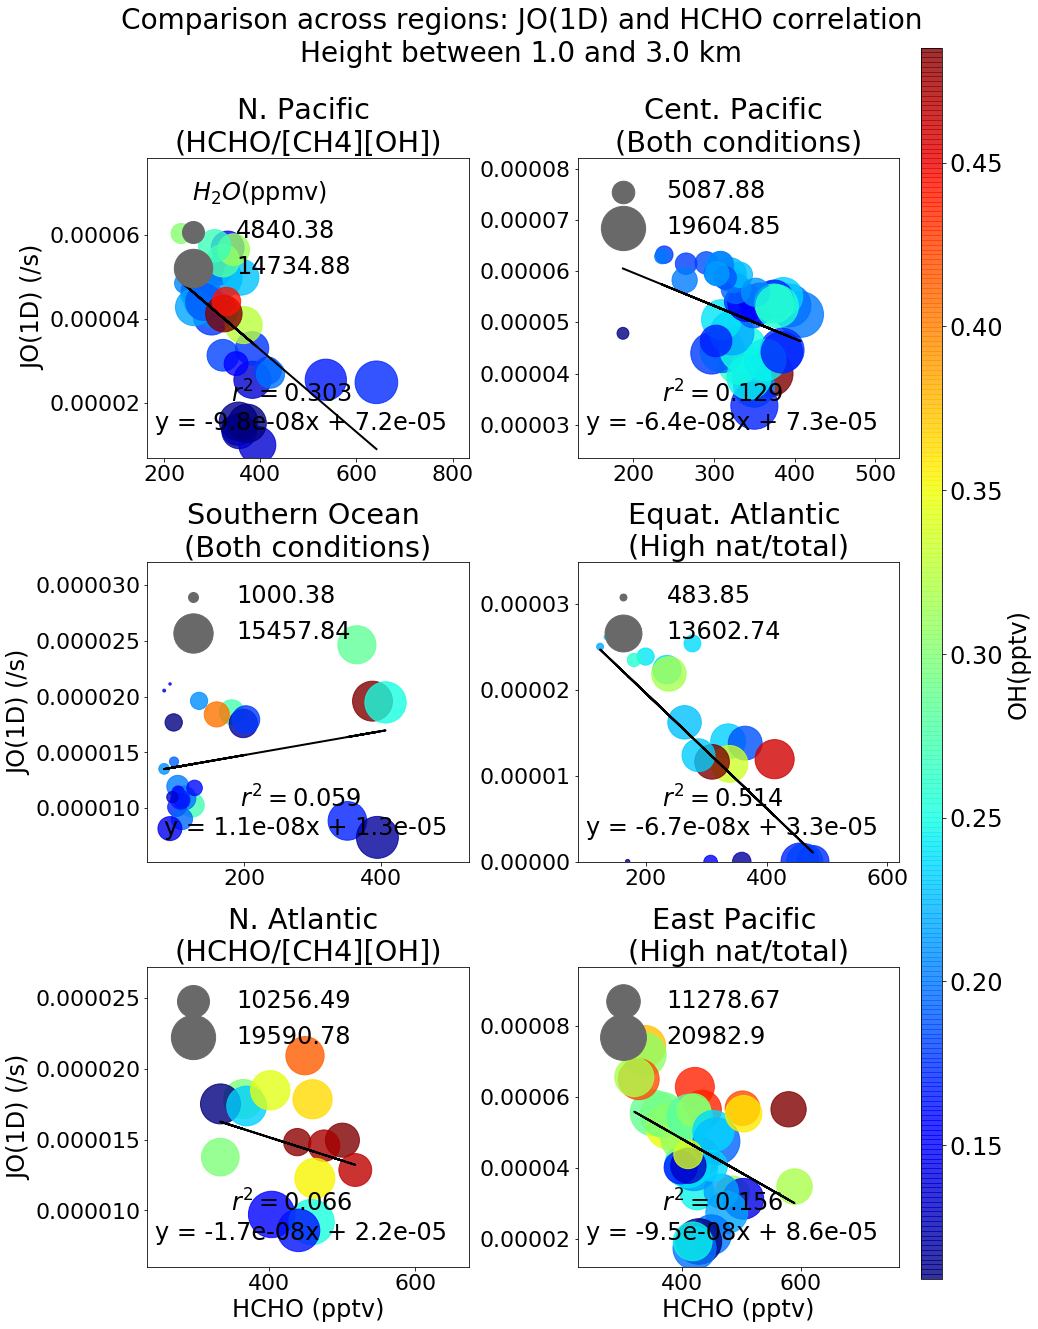

In [20]:
cor_reg_ht(rg_ttl_loc, 1e3, 3e3, 'JO(1D)', 'HCHO', 'OH', r'$H_2O$')
plt.savefig('jo1d_hcho_lin_lowp_oh_h2o.jpg')

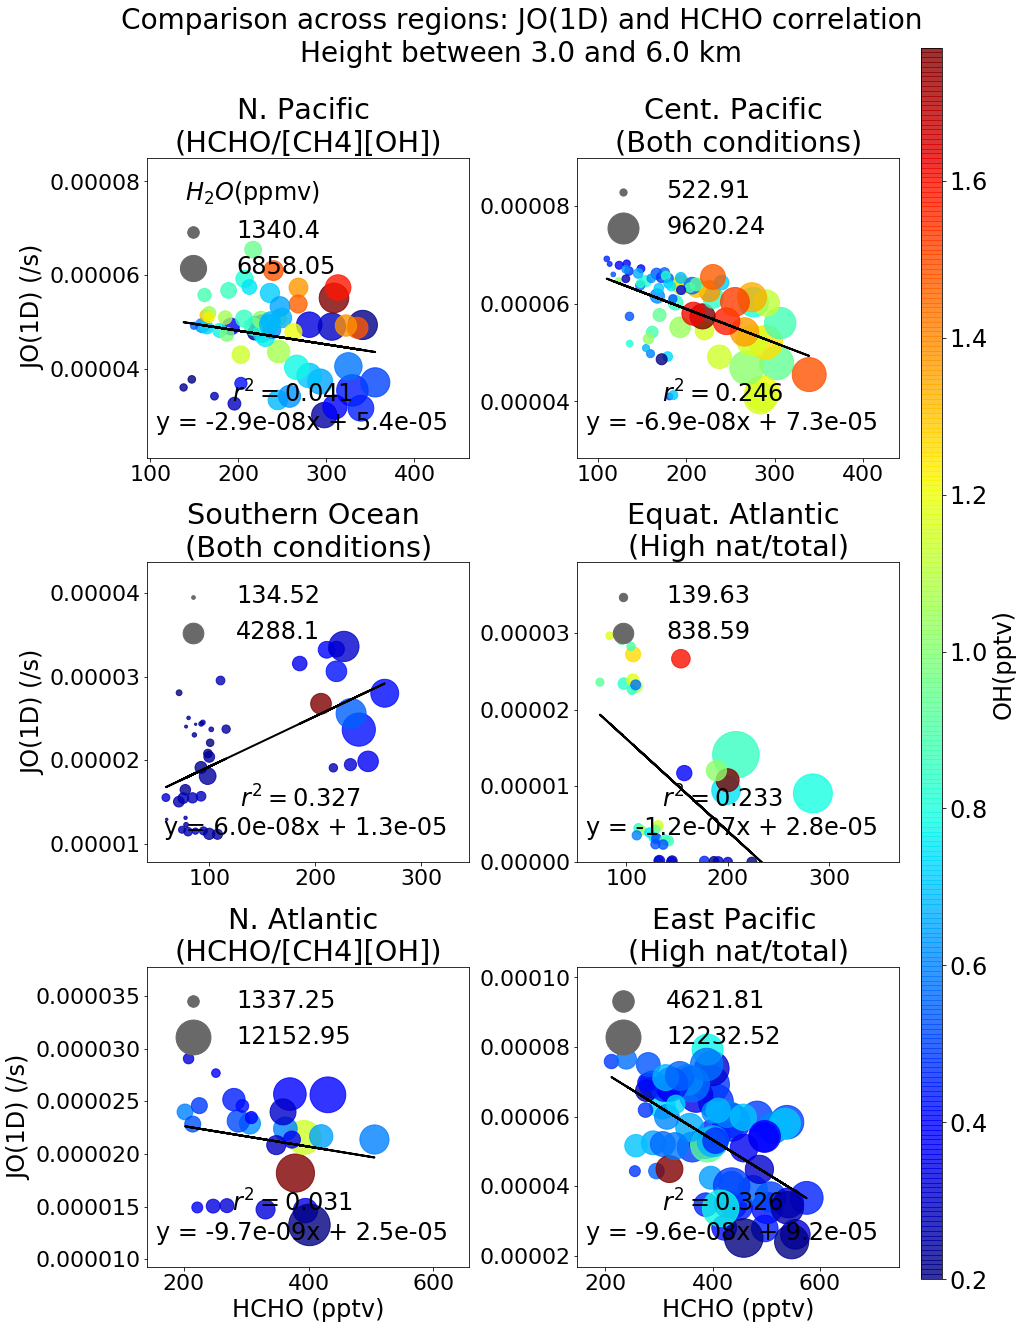

In [21]:
cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'JO(1D)', 'HCHO', 'OH', r'$H_2O$')
plt.savefig('jo1d_hcho_lin_highp_oh_h2o.jpg')

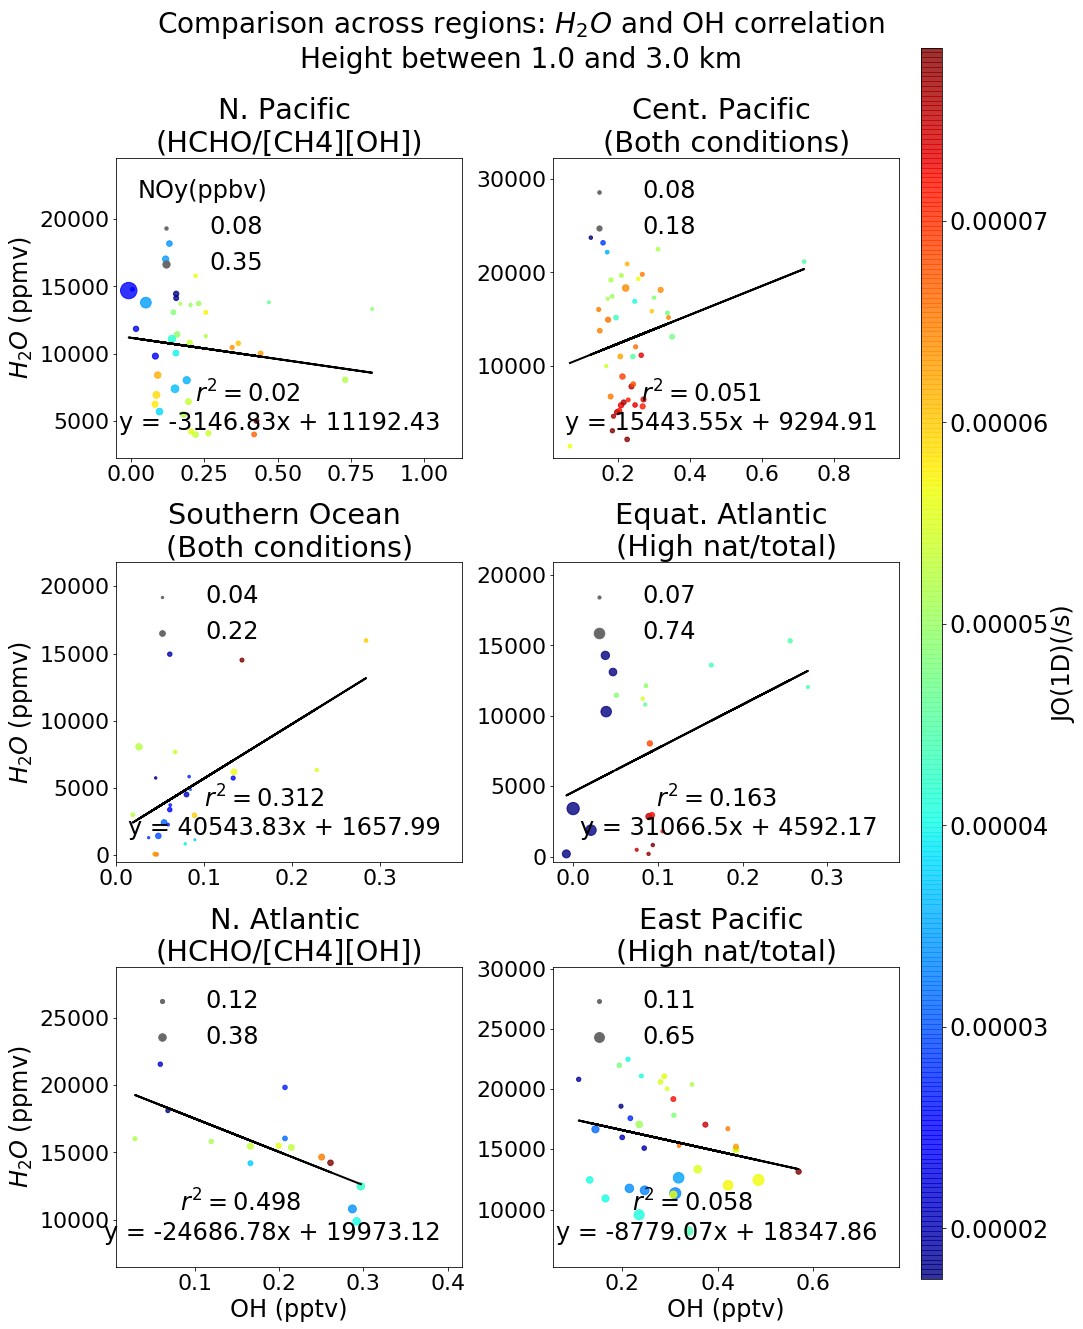

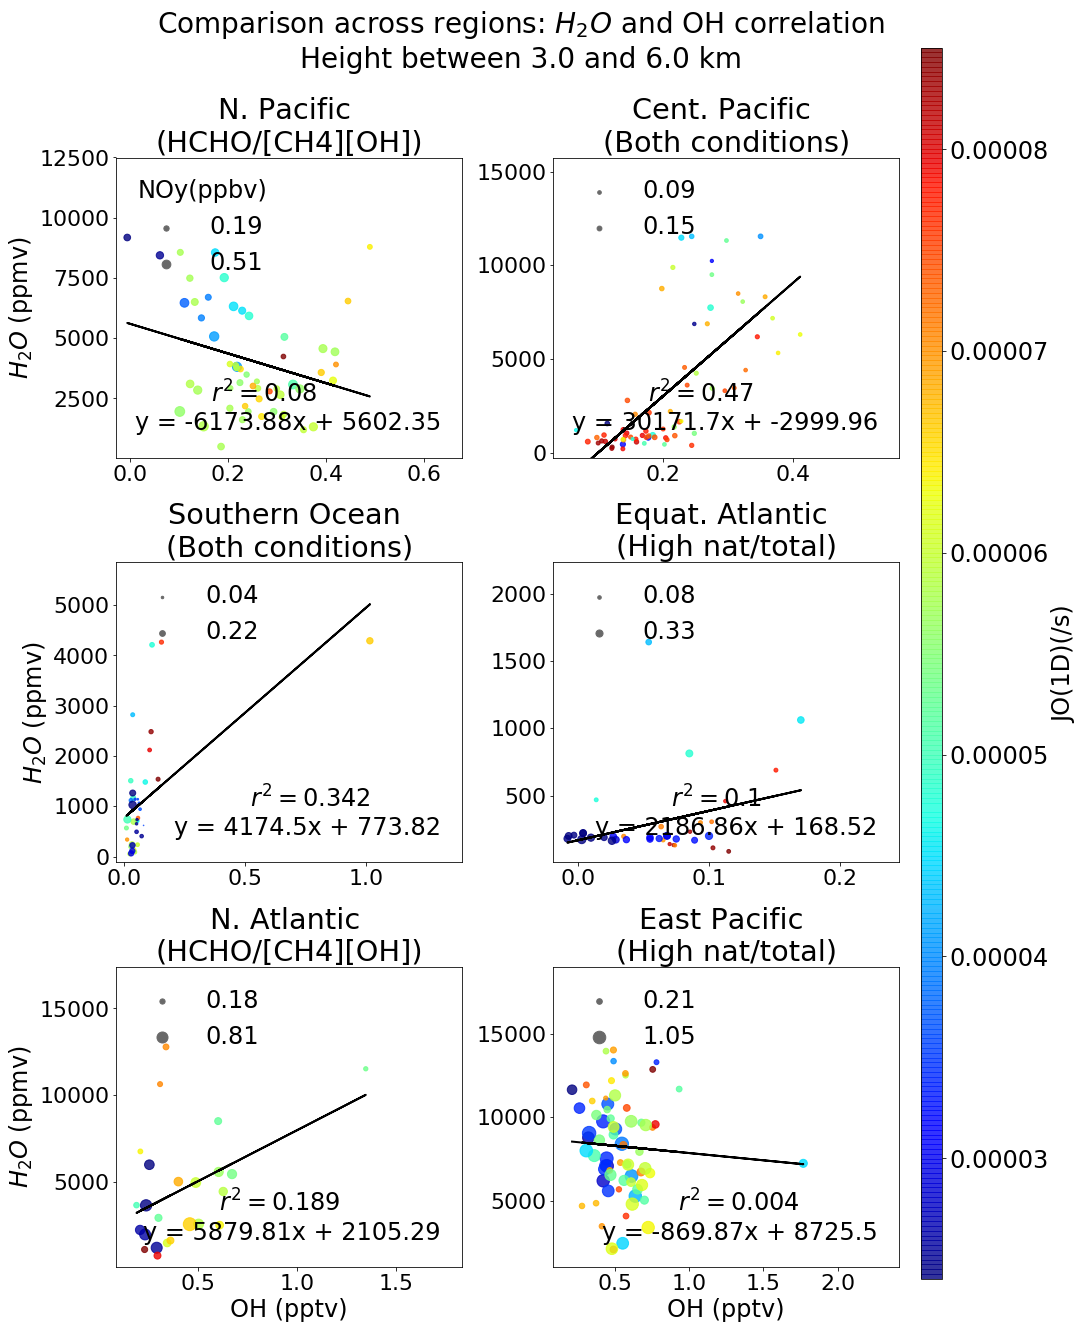

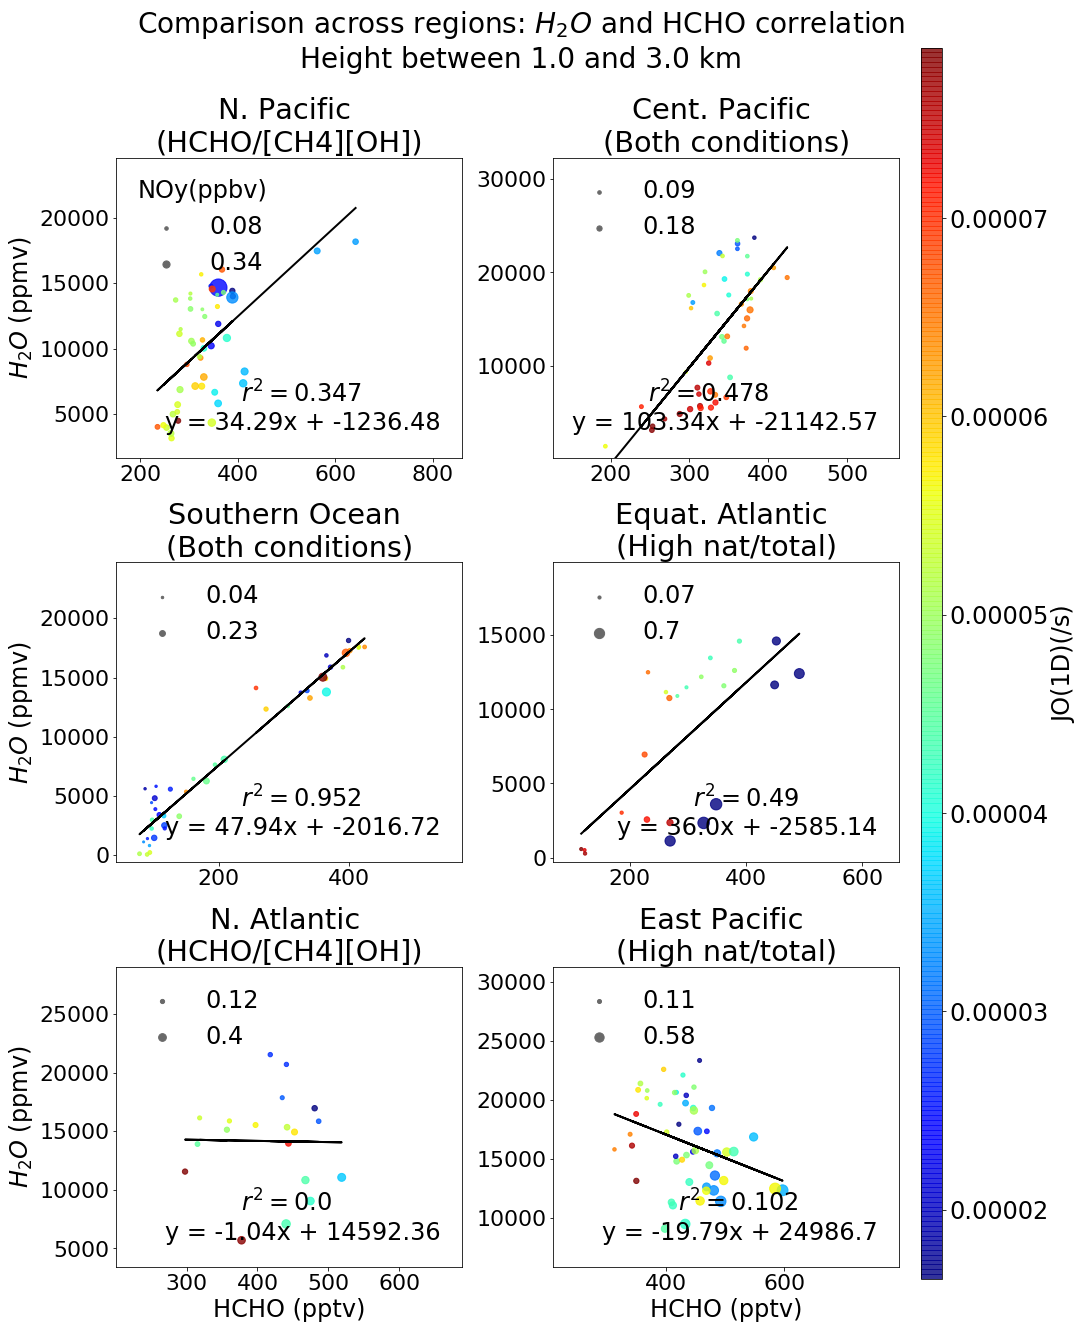

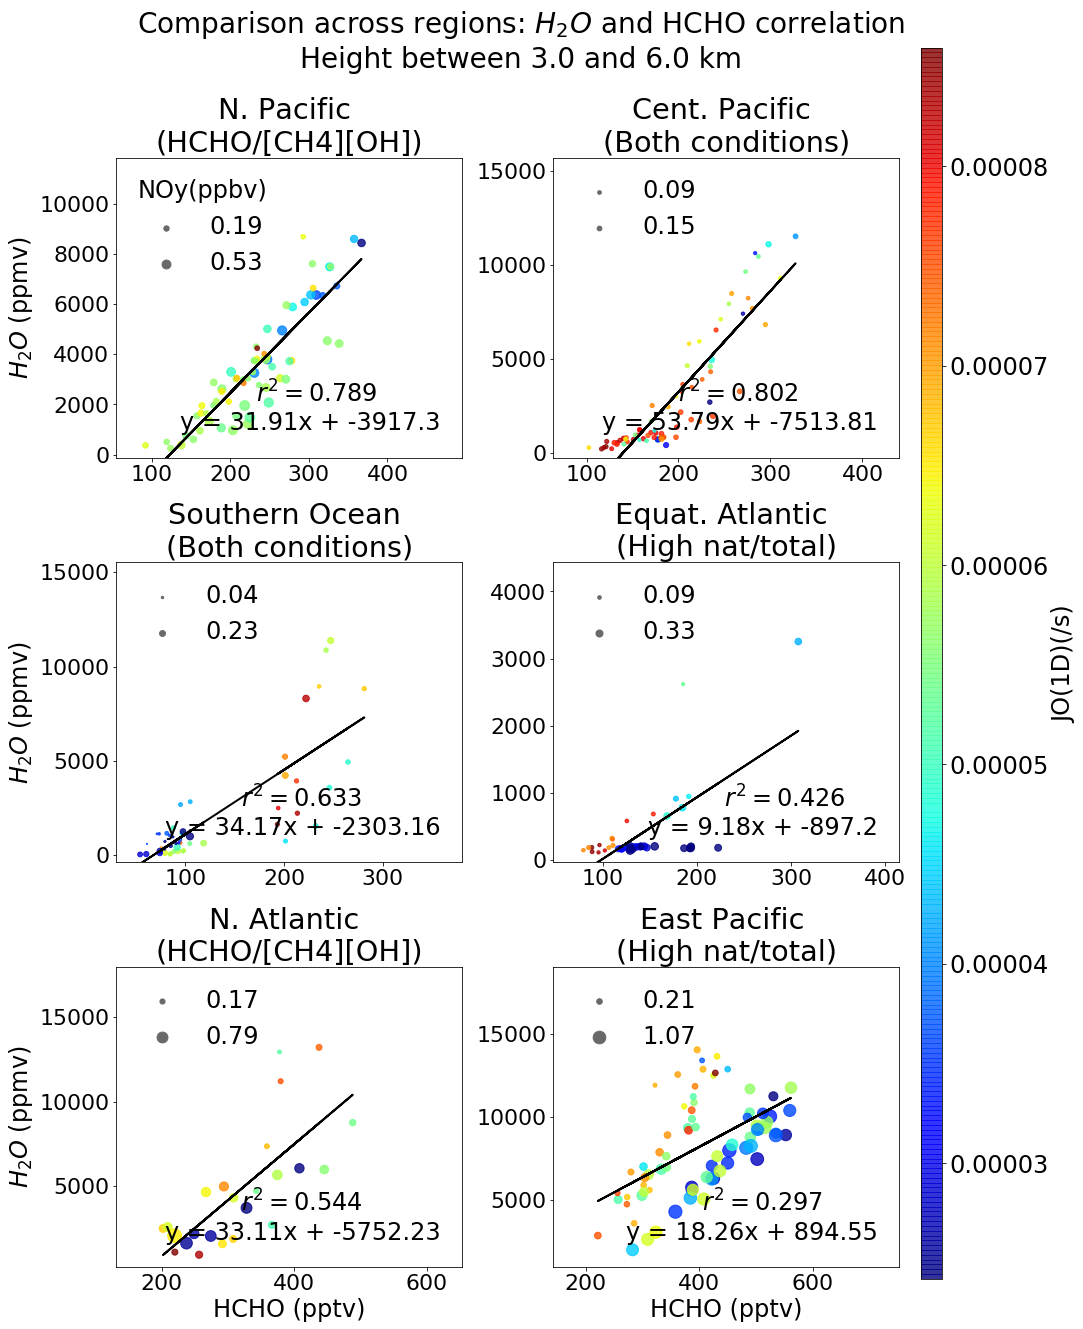

In [22]:
for spec in ['OH', 'HCHO']:
    for plev in [[1e3, 3e3], [3e3, 6e3]]:
        cor_reg_ht(rg_ttl_loc, plev[0], plev[1], r'$H_2O$', spec, 'JO(1D)', 'NOy')
        if plev[0]==1e3:
            plt.savefig('Figures/poster 07-17/forArlene_071717/h2o_' + spec + '_lowp_jo1d_noy.jpg')
        else:
            plt.savefig('Figures/poster 07-17/forArlene_071717/h2o_' + spec + '_highp_jo1d_noy.jpg')

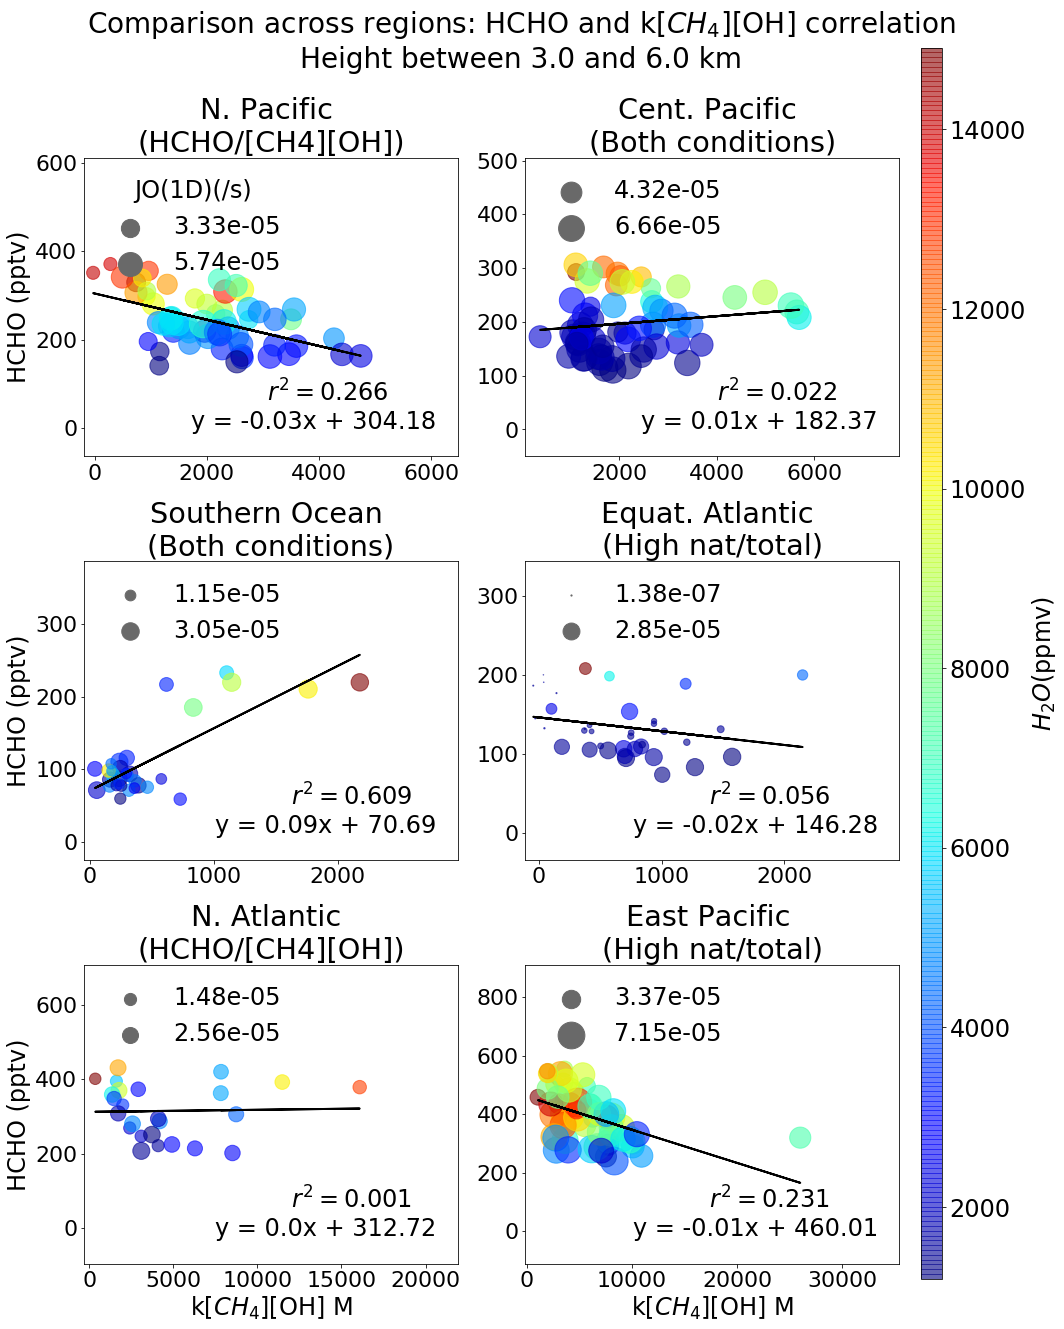

In [186]:
cor_reg_ht_rate(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'k[$CH_4$][OH]', r'$H_2O$', 'JO(1D)')

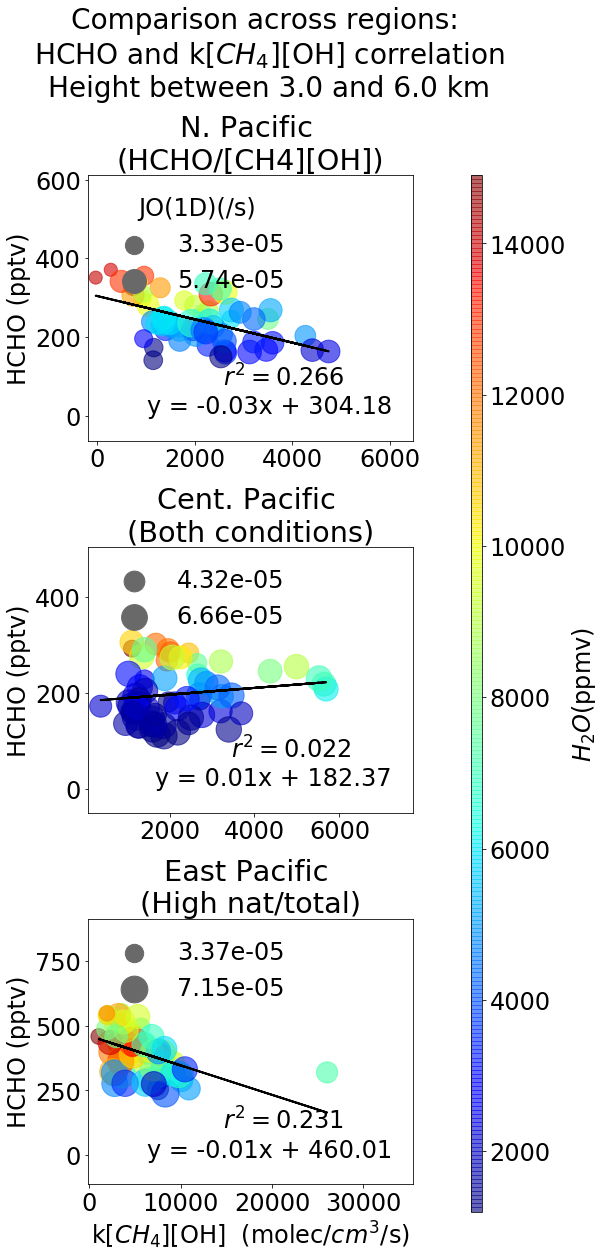

In [219]:
cor_reg_ht_rate(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'k[$CH_4$][OH]', r'$H_2O$', 'JO(1D)')

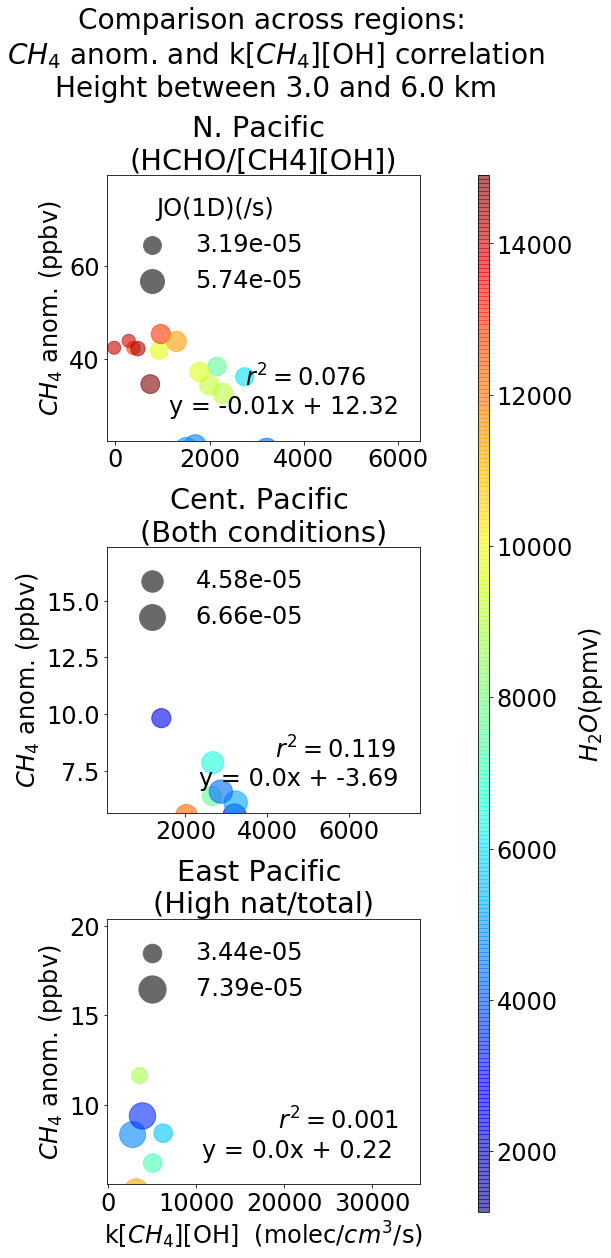

In [231]:
cor_reg_ht_rate(rg_ttl_loc, 3e3, 6e3, r'$CH_4$ anom.', 'k[$CH_4$][OH]', r'$H_2O$', 'JO(1D)')

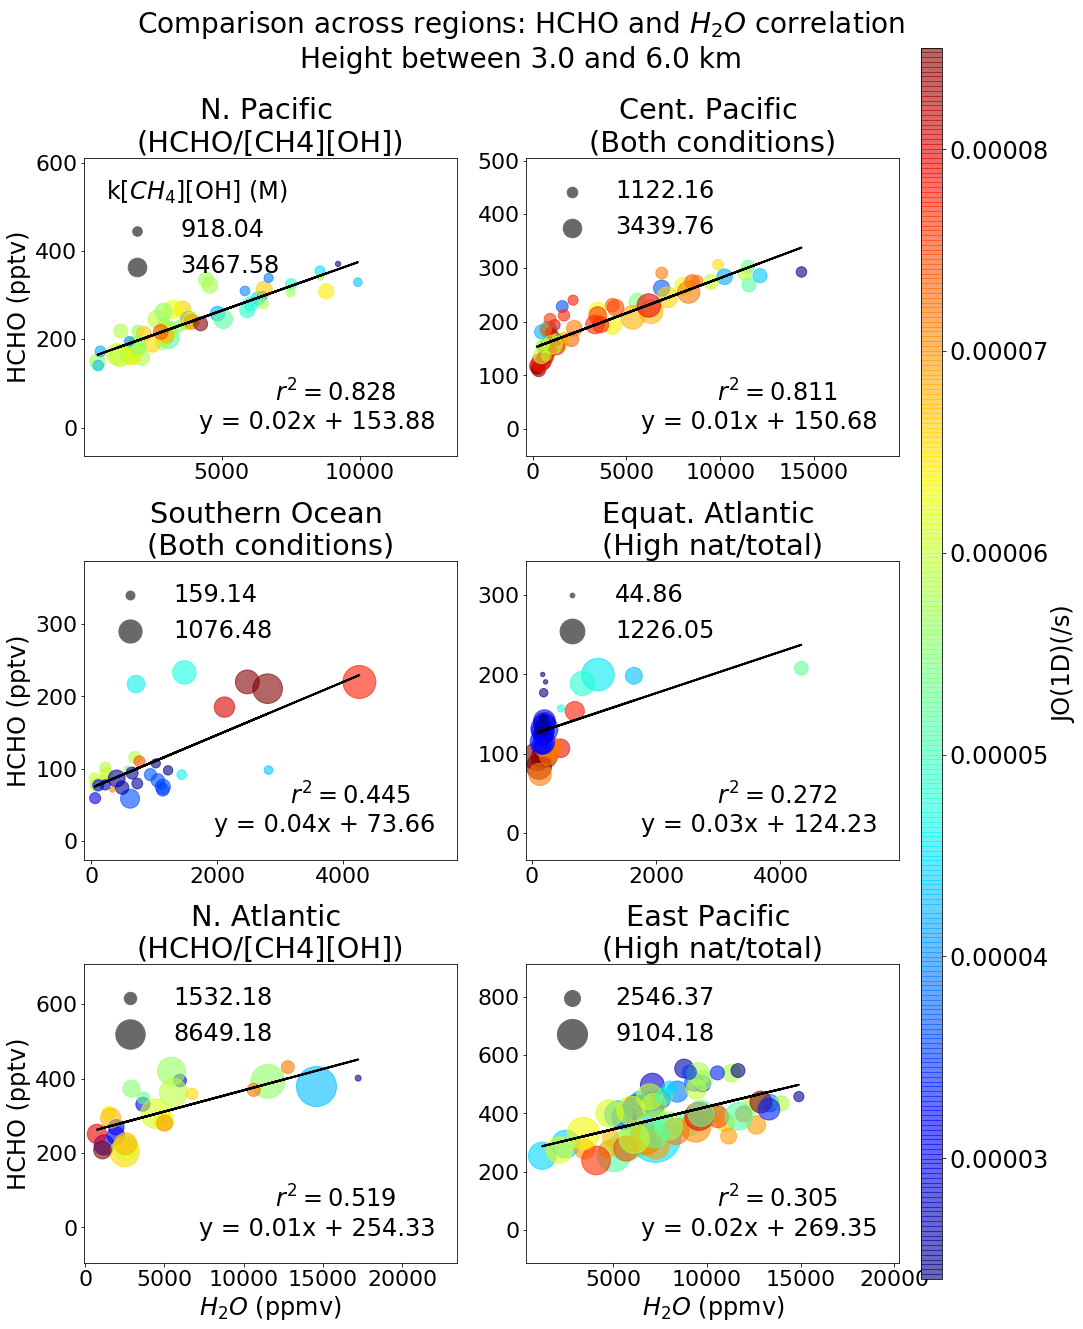

In [200]:
cor_reg_ht_rate(rg_ttl_loc, 3e3, 6e3, 'HCHO', r'$H_2O$', 'JO(1D)', 'k[$CH_4$][OH]')

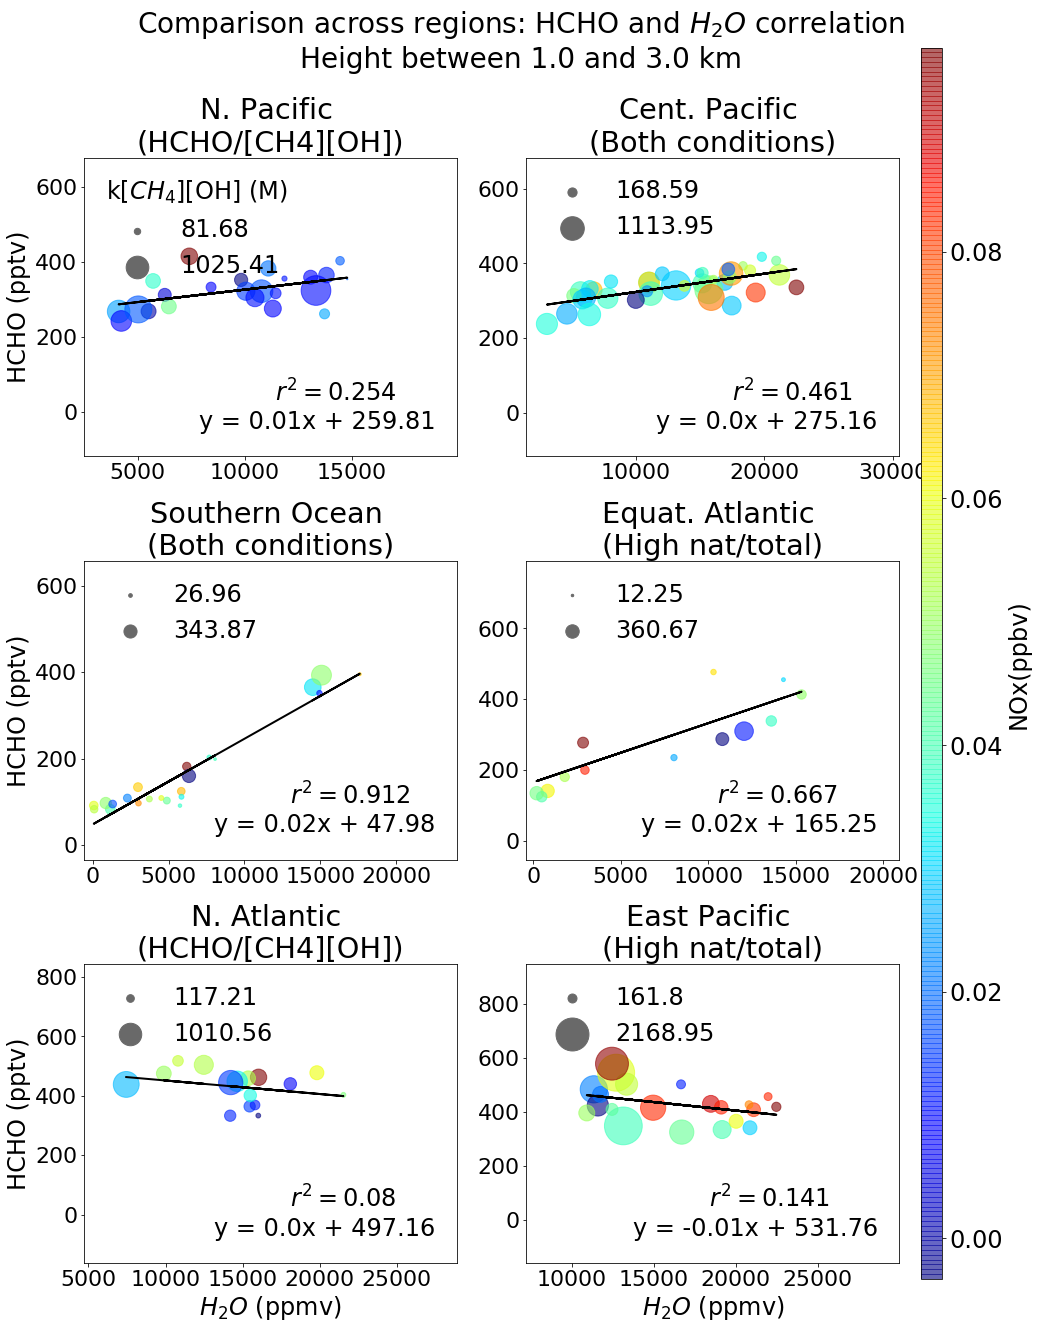

In [203]:
cor_reg_ht_rate(rg_ttl_loc, 1e3, 3e3, 'HCHO', r'$H_2O$', 'NOx', 'k[$CH_4$][OH]')

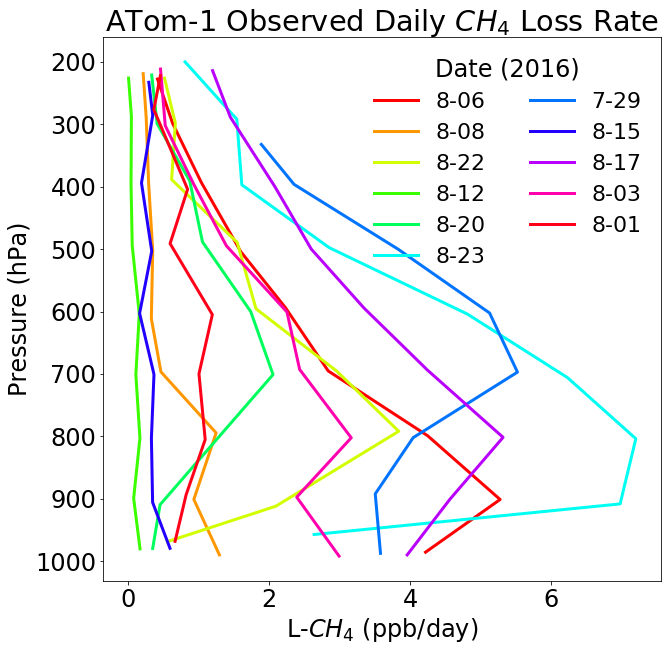

In [55]:
fig = plt.figure(figsize=[10,10])
cmap = plt.cm.get_cmap('hsv', len(set(atom.index.get_level_values(0))))
for idx, dt in list(enumerate(set(atom.index.get_level_values(0)))):
    subdat = atom.ix[dt]
    subdat = dropfill(dropfill(dropfill(dropfill(dropfill(dropfill(subdat, 
                'UTC_Start'), 'G_ALT'), 
                'CH4_NOAA'), 'T'), 'P'), 'OH_pptv')
    subdat['UTC_Start'] = pd.to_datetime(subdat['UTC_Start'], utc=True)
    subdat = subdat.set_index('UTC_Start')
    subdat = subdat.resample('60N').mean() # 10-min averaging
    subdat['pint'] = np.round(subdat['P'], -2)
    subdat = subdat.groupby('pint').mean()
    alt = (np.ma.masked_invalid(subdat['G_ALT']))/1e3
    prs = np.ma.masked_invalid(subdat['P'])
    tmp = np.ma.masked_invalid(subdat['T'])
    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
    oh = np.ma.masked_invalid(subdat['OH_pptv'])
    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
    oh = np.ma.masked_invalid(subdat['OH_pptv'])
    tmp = np.ma.masked_invalid(subdat['T'])
    prs = np.ma.masked_invalid(subdat['P'])
    k = rate['k[$CH_4$][OH]'] # cm^3/molec/s
    # moles of air = 1e9/(6.023*1e23) = 1.66e-15 mol
    # 9.86923e-6 atm/1 hPa
    # V = nRT/p * 1e3 (to convert cm^3 from L)
    vol = (1.66*1e-15 * 0.0821 * tmp)/(prs * 9.86923e-4) * 1e3
    ch4_molec = ch4/vol
    oh_molec = oh*1e-3/vol
    ch4_loss = (tmp**(2.82))*k*np.exp(-987/tmp)*ch4_molec*oh_molec
    ch4l_ppbd = (ch4_loss * vol) * (60*60*24)
    
    leglab = dt[-3:-2] + '-' + dt[-2:]
    plt.plot(ch4l_ppbd, prs, color=cmap(idx), label=leglab, linewidth=3)
    plt.gca().invert_yaxis()
    plt.legend(loc=1, title='Date (2016)', ncol=2, fontsize=22, frameon=False)
    plt.title('ATom-1 Observed Daily $CH_4$ Loss Rate')
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('L-$CH_4$ (ppb/day)')

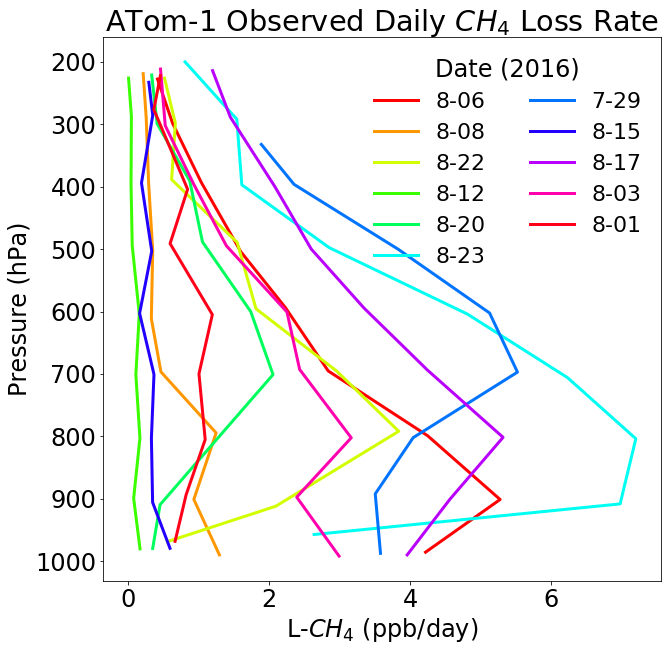

In [42]:
fig = plt.figure(figsize=[10,10])
cmap = plt.cm.get_cmap('hsv', len(set(atom.index.get_level_values(0))))
for idx, dt in list(enumerate(set(atom.index.get_level_values(0)))):
    subdat = atom.ix[dt]
    subdat = dropfill(dropfill(dropfill(dropfill(dropfill(dropfill(subdat, 
                'UTC_Start'), 'G_ALT'), 
                'CH4_NOAA'), 'T'), 'P'), 'OH_pptv')
    subdat['UTC_Start'] = pd.to_datetime(subdat['UTC_Start'], utc=True)
    subdat = subdat.set_index('UTC_Start')
    subdat = subdat.resample('60N').mean() # 10-min averaging
    subdat['pint'] = np.round(subdat['P'], -2)
    subdat = subdat.groupby('pint').mean()
    alt = (np.ma.masked_invalid(subdat['G_ALT']))/1e3
    prs = np.ma.masked_invalid(subdat['P'])
    tmp = np.ma.masked_invalid(subdat['T'])
    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
    oh = np.ma.masked_invalid(subdat['OH_pptv'])
    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
    oh = np.ma.masked_invalid(subdat['OH_pptv'])
    tmp = np.ma.masked_invalid(subdat['T'])
    prs = np.ma.masked_invalid(subdat['P'])
    k = rate['k[$CH_4$][OH]'] # cm^3/molec/s    
    #na = AvP/(RT)
    #Where n_a = # density (molecules/cm3) where a = air; Av = avagadro’s number; P = pressure (hopefully reported along flight track!); 
    #R = gas constant 8.314 Jmol-1K-1
    #T = temperature (also should be reported in merge, in K)
    #Then n_species = c_species * n_a
    # c_species = molar mixing ratio and n_species = number density of species
    #Don’t forget to convert from ppt (1 ppt = 1x10^-12 moles species / moles air) or ppm.
    na = (6.022e23 * prs*1e2) / (8.3145*1e6 * tmp)
    ch4_molec = (ch4 * 1e-9) * na
    oh_molec = (oh * 1e-12) * na
    ch4_loss = (tmp**(2.82))*k*np.exp(-987/tmp)*ch4_molec*oh_molec
    ch4l_ppbd = ((ch4_loss/1e-9) / na) * (60*60*24)
    
    leglab = dt[-3:-2] + '-' + dt[-2:]
    plt.plot(ch4l_ppbd, prs, color=cmap(idx), label=leglab, linewidth=3)
    plt.gca().invert_yaxis()
    plt.legend(loc=1, title='Date (2016)', ncol=2, fontsize=22, frameon=False)
    plt.title('ATom-1 Observed Daily $CH_4$ Loss Rate')
    plt.ylabel('Pressure (hPa)')
    plt.xlabel('L-$CH_4$ (ppb/day)')

In [16]:
def cor_reg_ht(regions, minht, maxht, spec, corvar, colvar, sizvar, color_sub, loglog):
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    leg_reg = ['N Pac', 'C Pac', 'S Ocn', 'Eq Atl', 'N Atl', 'E Pac']
    markers = ['o', '>', '<', 'x', '+', '^']
    plsp_all = []
    xvals_all = []
    size_all = []

    for idx, reg in list(enumerate(regions)):
        df_sub = atom[atom['G_LAT']>regions[reg][0][0]]
        df_sub = df_sub[df_sub['G_LAT']<regions[reg][0][1]]
        df_sub = df_sub[df_sub['G_LONG']>regions[reg][1][0]]
        df_sub = df_sub[df_sub['G_LONG']<regions[reg][1][1]]
        df_sub = df_sub[df_sub['G_ALT']>minht]
        df_sub = df_sub[df_sub['G_ALT']<maxht]
        dates = set(df_sub.index.get_level_values(0))
    
        for dt in dates:
            subdat = df_sub.ix[dt]
            
            # The next block of text resamples the merge from 10-s intervals to X0-min intervals
            # to reduce noise inherent in the dataset. It is necessary to subset by any "character"
            # variables and to remove missing values from the time variables to use the resample function.
            #subdat = dropfill(dropfill(dropfill(dropfill(dropfill(subdat, 
            #            'UTC_Start'), 'AMS_MidPointTime'), 'G_ALT'), reg_cv[corvar][0]), reg_cv[sizvar][0])
            subdat = dropfill(dropfill(dropfill(subdat, 
                        'UTC_Start'), 'AMS_MidPointTime'), 'G_ALT')
            for t in reg_cv[sizvar]:
                subdat = dropfill(subdat, t)
            for u in reg_cv[colvar]:
                subdat = dropfill(subdat, u)
            for v in reg_cv[spec]:
                subdat = dropfill(subdat, v)
            for w in reg_cv[corvar]:
                subdat = dropfill(subdat, w)
            subdat['UTC_Start'] = pd.to_datetime(subdat['UTC_Start'], utc=True)
            subdat = subdat.set_index('UTC_Start')
            subdat = subdat.resample('60N').mean() # 10-min averaging
            if len(subdat) < 10:
                continue
            # Retrieve and prepare variables to plot as arrays (masked where missing)
            pres = (np.ma.masked_invalid(subdat['G_ALT']))/1e3
            time = np.ma.masked_invalid(subdat['AMS_MidPointTime'])/(60*60)
            
            math_var = {}
            for var in [spec, corvar, colvar, sizvar]:
                if var==r'$CH_4$ anom.':
                    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
                    if var==sizvar:
                        anom = ch4 - ch4.mean()
                        math_var[var] = abs(anom)
                    else:
                        math_var[var] = ch4 - ch4.mean()
                elif var==r'$CH_4:NOy$':
                    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
                    ch4 = ch4 - ch4.mean()
                    noy = np.ma.masked_invalid(subdat['NOy_CL'])
                    math_var[var] = ch4/noy
                elif var=='CO:NOx':
                    co = np.ma.masked_invalid(subdat['CO_NOAA'])
                    no = np.ma.masked_invalid(subdat['NO_CL'])
                    no2 = np.ma.masked_invalid(subdat['NO2_CL'])
                    nox = no + no2
                    math_var[var] = co/nox
                elif var=='CO:NOy':
                    co = np.ma.masked_invalid(subdat['CO_NOAA'])
                    noy = np.ma.masked_invalid(subdat['NOy_CL'])
                    math_var[var] = co/noy
                elif var==r'$H_2O$':
                    h2o = np.ma.masked_invalid(subdat['H2O_ppmv'])
                    math_var[var] = h2o/1e3
                elif var=='HOx':
                    ho = np.ma.masked_invalid(subdat['OH_pptv'])
                    ho2 = np.ma.masked_invalid(subdat['HO2_pptv'])
                    math_var[var] = ho + ho2
                elif var=='k[$CH_4$][OH]':
                    ch4 = np.ma.masked_invalid(subdat['CH4_NOAA'])
                    oh = np.ma.masked_invalid(subdat['OH_pptv'])
                    tmp = np.ma.masked_invalid(subdat['T'])
                    prs = np.ma.masked_invalid(subdat['P'])
                    k = rate[var] # cm^3/molec/s
                    # Original method
                    # moles of air = 1e9/(6.023*1e23) = 1.66e-15 molecules
                    # 9.86923e-4 atm/1 hPa
                    # V = nRT/p * 1e3 (to convert cm^3 from L)
                    vol = (1.66*1e-15 * 0.0821 * tmp)/(prs * 9.86923e-4) * 1e3
                    ch4_molec = ch4/vol
                    oh_molec = oh*1e-3/vol
                    ch4l_mcms = (tmp**(2.82))*k*np.exp(-987/tmp)*ch4_molec*oh_molec
                    math_var[var] = ch4l_mcms * vol * (60*60*24)
                elif var=='NOx':
                    no = np.ma.masked_invalid(subdat['NO_CL'])
                    no2 = np.ma.masked_invalid(subdat['NO2_CL'])
                    nox = no + no2
                    math_var[var] = nox
                elif var=='NOx:NOy':
                    no = np.ma.masked_invalid(subdat['NO_CL'])
                    no2 = np.ma.masked_invalid(subdat['NO2_CL'])
                    nox = no + no2
                    noy = np.ma.masked_invalid(subdat['NOy_CL'])
                    math_var[var] = nox/noy
                elif var=='OH':
                    oh = np.ma.masked_invalid(subdat['OH_pptv'])
                    sza = np.ma.masked_invalid(subdat['Solar_Zenith_Angle'])
                    math_var[var] = oh/(1-np.sin(sza))
                else:
                    math_var[var] = np.ma.masked_invalid(subdat[reg_cv[var]])

            tmp_vars = [spec, corvar, colvar, sizvar]
            for v in tmp_vars:
                if v in ['NOx', 'CO:NOx', 'NOx:NOy']:
                    for var in tmp_vars:
                        math_var[var] = math_var[var][nox>0]
                    break
            
            if loglog==True:
                for v in tmp_vars:
                    if math_var[v].any() < 0:
                        for var in tmp_vars:
                            math_var[var] = np.array(math_var[var][math_var[v]>0])
                                
            xvals = math_var[corvar].squeeze()
            plsp = math_var[spec].squeeze()
            color = math_var[colvar].squeeze()
            size = math_var[sizvar].squeeze()
                        
            time = reject_outliers(plsp, time, m=2)
            pres = reject_outliers(plsp, pres, m=2)
            xvals = reject_outliers(plsp, xvals, m=2)
            color = reject_outliers(plsp, color, m=2)
            size = reject_outliers(plsp, size, m=2)
            plsp = reject_outliers(plsp, plsp, m=2)
            
            if colvar=='Temp.':
                color = color - 273.
            if sizvar=='Temp.':
                size = size - 273.
            
            if np.mean(size)<1e-5:
                sf = 1e11
            elif np.mean(size)<1e-3:
                sf = 1e7
            elif np.mean(size)<1e-1:
                sf = 5000
            elif np.mean(size) < 1:
                sf = 1e3
            elif np.mean(size)/10 < 1:
                sf = 10
            elif np.mean(size)/50<1:
                sf = 5
            elif np.mean(size)/100<1:
                sf = 1
            elif np.mean(size)/1e3<1:
                sf = 0.5
            elif np.mean(size)/1e5<1:
                sf = 0.1
            else:
                sf = 0.05
                        
            if color_sub==True:
                plsp = plsp[color>np.median(color)]
                xvals = xvals[color>np.median(color)]
                color = color[color>np.median(color)]
                size = size[color>np.median(color)]

            if loglog==True:
                plsp = np.log(plsp)
                xvals = np.log(xvals)
                
            plsp_all = np.append(plsp_all, plsp)
            xvals_all = np.append(xvals_all, xvals)
            size_all = np.append(size_all, size)
            
            if idx==0:
                vmin = color.min()
                vmax = color.max()
                
            im = ax.scatter(xvals, plsp, marker=markers[idx], c=color, s=size*sf, vmin=vmin, vmax=vmax)
            
#    if minht==3e3 and maxht==6e3 and corvar=='OH':
#        dpdt = pd.DataFrame({spec: plsp_all[xvals_all<1.4]})
#        indt = pd.DataFrame({corvar: xvals_all[xvals_all<1.4]})
#        lm = linear_model.LinearRegression()
#        lm.fit(indt, dpdt)
    if minht==3e3 and maxht==6e3 and spec=='NOx:NOy' and loglog==True:
        dpdt = pd.DataFrame({spec: plsp_all[plsp_all>-6]})
        indt = pd.DataFrame({corvar: xvals_all[plsp_all>-6]})
        lm = linear_model.LinearRegression()
        lm.fit(indt, dpdt)        
    else:
        dpdt = pd.DataFrame({spec: plsp_all})
        indt = pd.DataFrame({corvar: xvals_all})
        lm = linear_model.LinearRegression()
        lm.fit(indt, dpdt)            

    ax.plot(indt[corvar], lm.predict(indt), c='k', linewidth=2)
    if spec=='NOy':
        sym='x '
    else:
        sym='x + '
    if spec!='JO(1D)':
        pear = AnchoredText('          ' + r'$r^2 = $' + str(np.round(lm.score(indt, dpdt), 3))
                    + '\ny = ' + str(np.round(lm.coef_[0][0], 2)) + sym + str(np.round(lm.intercept_[0], 2)),
                    loc=3, frameon=False)
    else:
        pear = AnchoredText('          ' + r'$r^2 = $' + str(np.round(lm.score(indt, dpdt), 3))
                    + '\ny = ' + '{0:.1e}'.format(lm.coef_[0][0]) + sym + '{0:.1e}'.format(lm.intercept_[0]),
                    loc=3, frameon=False)
        
    ax.add_artist(pear)
    if loglog==True:
        ax.set_ylabel('log(' + spec + ') ' + units[spec])
        ax.set_xlabel('log(' + corvar + ') ' + units[corvar])
    else:
        ax.set_ylabel(spec + ' ' + units[spec])
        ax.set_xlabel(corvar + ' ' + units[corvar])
        
    leg_sizes = [np.percentile(size_all, f) for f in [10, 90]] 
    dum_sm = plt.scatter([],[], s=sf*leg_sizes[0], color='black')
    dum_md = plt.scatter([],[], s=sf*leg_sizes[1], color='black')
    reg1 = plt.scatter([], [], marker=markers[0], color='black', s=60, label=leg_reg[0])
    reg2 = plt.scatter([], [], marker=markers[1], color='black', s=60, label=leg_reg[1])
    reg3 = plt.scatter([], [], marker=markers[2], color='black', s=60, label=leg_reg[2])
    reg4 = plt.scatter([], [], marker=markers[3], color='black', s=60, label=leg_reg[3])
    reg5 = plt.scatter([], [], marker=markers[4], color='black', s=60, label=leg_reg[4])
    reg6 = plt.scatter([], [], marker=markers[5], color='black', s=60, label=leg_reg[5])
    
    reg_legend = plt.legend(handles=[reg1, reg2, reg3, reg4, reg5, reg6], title='Regions', loc=4, frameon=False)
    plt.legend((dum_sm, dum_md),
                    ('{0:.2e}'.format(leg_sizes[0]), '{0:.2e}'.format(leg_sizes[1])), 
                    title=sizvar + ' ' + units[sizvar],
                    scatterpoints=1, loc='upper left', frameon=False)
    plt.gca().add_artist(reg_legend)
        
    #if minht==3e3 and maxht==6e3 and corvar=='OH' and loglog==False:
    #    ax.set_xlim([-0.05, 1.0])
    if minht==3e3 and maxht==6e3 and spec=='NOx:NOy' and loglog==True:
        ax.set_ylim([-5, 0])
    plt.margins(0.05, 0.2)
    plt.title('Across regions: ' + spec + ' vs ' + corvar
                 + '\nHeight between ' + str(np.round(df_sub['G_ALT'].min()/1e3, 1)) + ' and ' 
                 + str(np.round(df_sub['G_ALT'].max()/1e3, 1)) + ' km', fontsize=28)
    plt.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.05, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cbar_ax)
    if color_sub==True:
        cbar.set_label(colvar + units[colvar] + ': Data subset below mean (' + str(np.round(color.mean(), 1)) + ')')
    else:
        cbar.set_label(colvar + units[colvar])

## HCHO vs OH colored by $H_2O$ and between 1 and 3 km

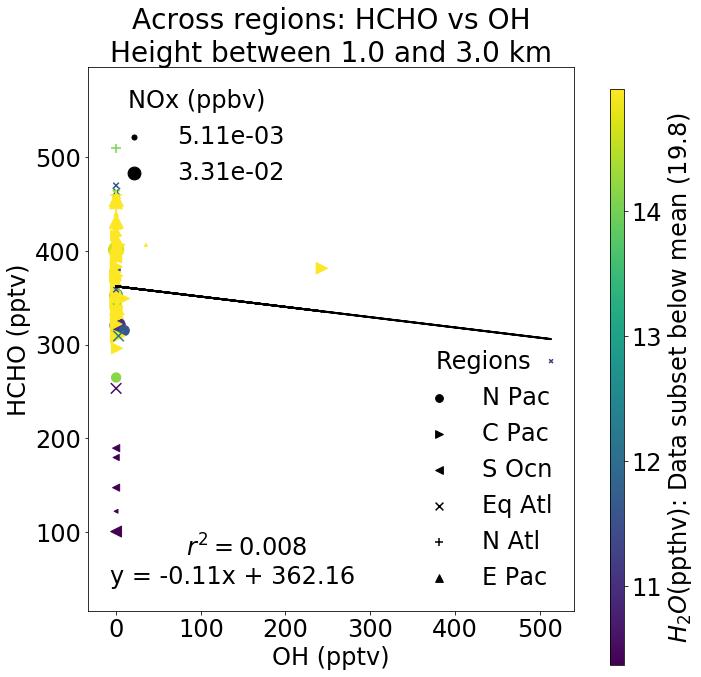

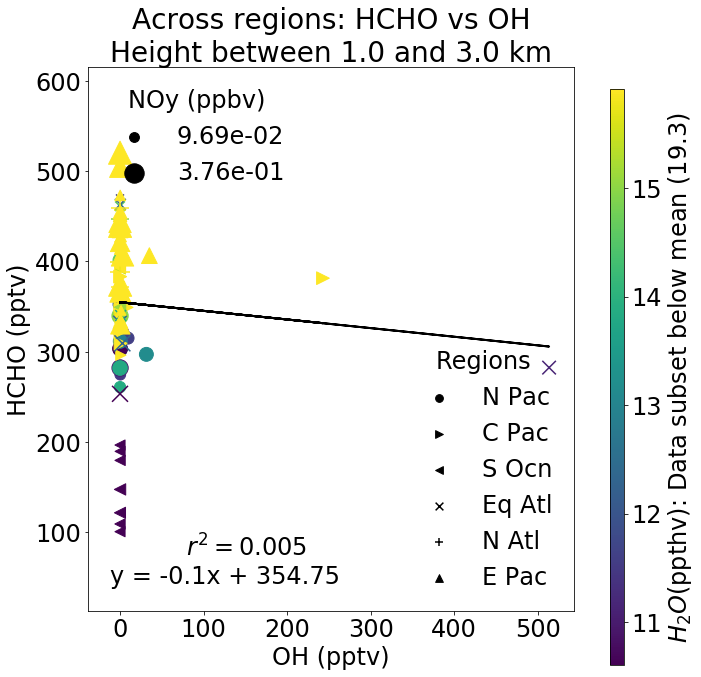

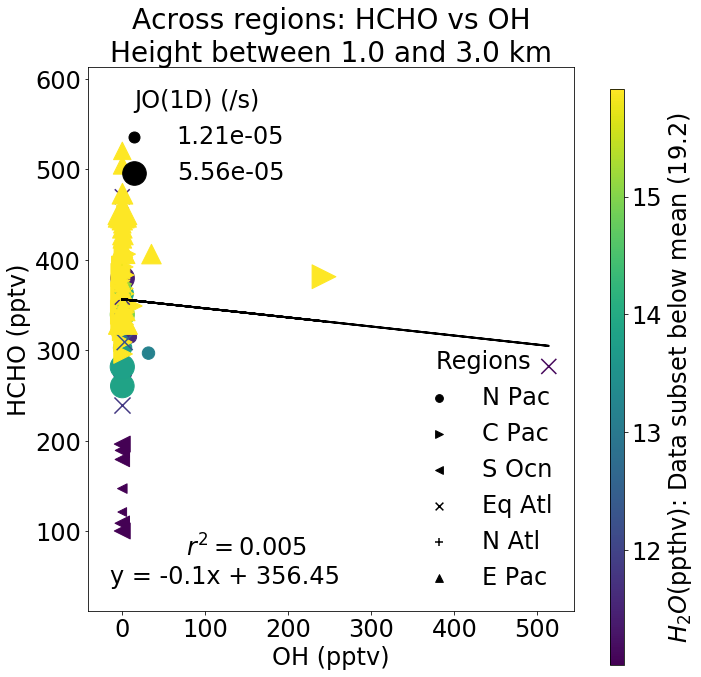

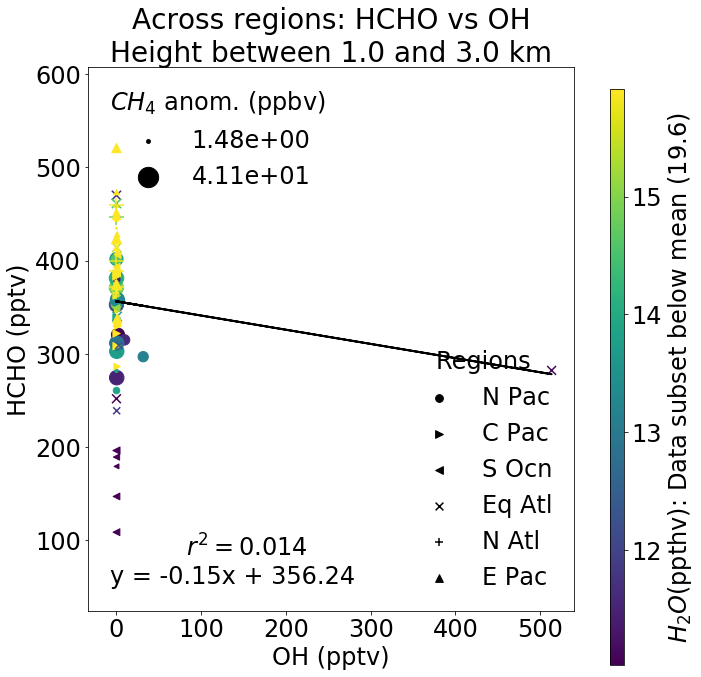

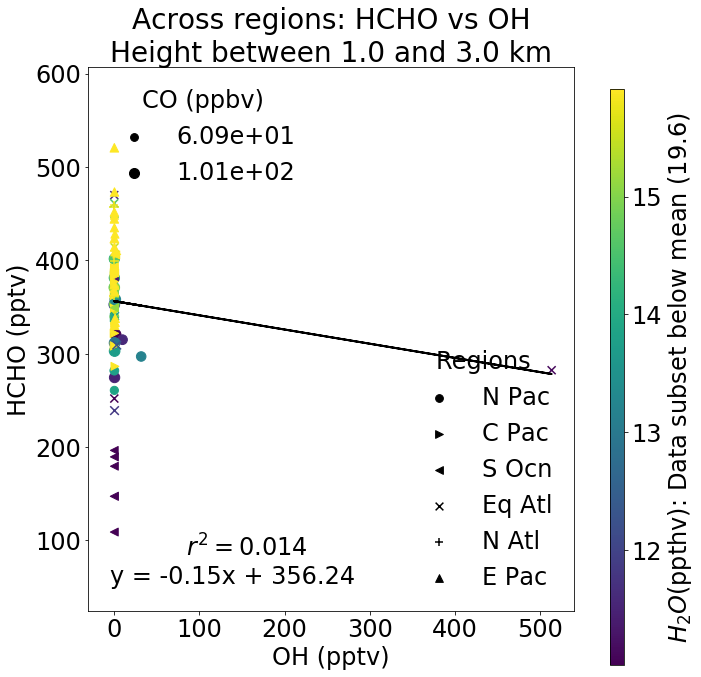

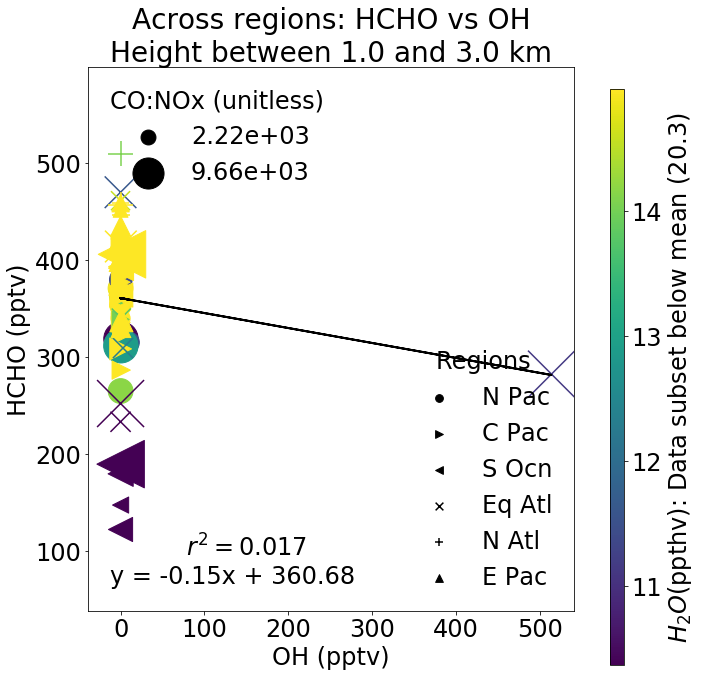

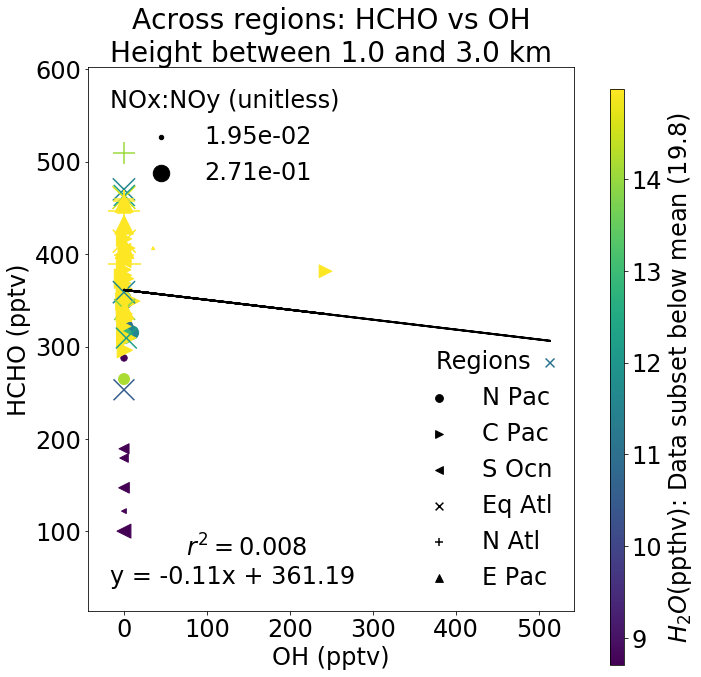

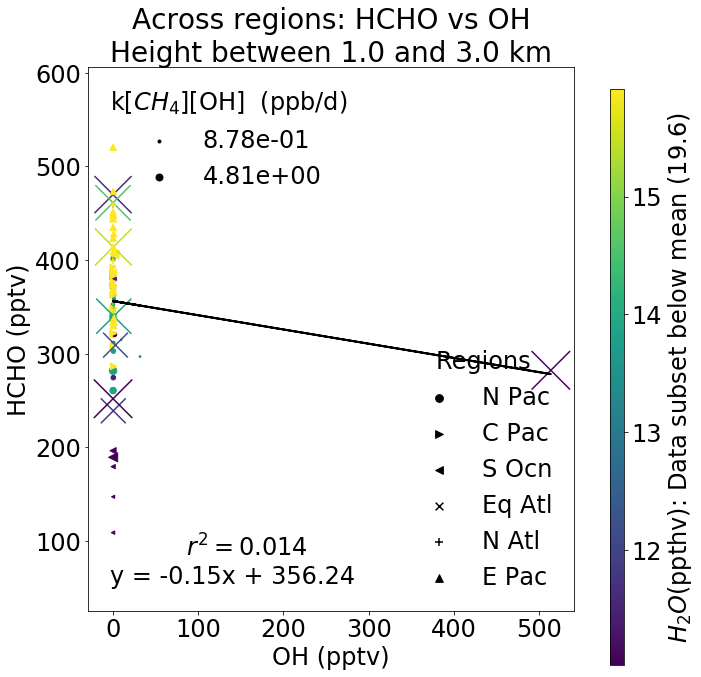

In [17]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'NOx:NOy', 'k[$CH_4$][OH]']:
    cor_reg_ht(rg_ttl_loc, 1e3, 3e3, 'HCHO', 'OH', r'$H_2O$', var, True, False)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var=='k[$CH_4$][OH]':
        pol='kch4oh'
    else:
        pol=var
    #plt.savefig('Figures/poster 07-17/newreg_071817/corr_1-3km/hcho_oh/' + pol.lower() + '.jpg')

## HCHO vs OH colored by $H_2O$ between 3-6km

In [ ]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'NOx:NOy', 'k[$CH_4$][OH]']:
    cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'OH', r'$H_2O$', var, True, False)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var=='k[$CH_4$][OH]':
        pol='kch4oh'
    else:
        pol=var
    plt.savefig('Figures/poster 07-17/newreg_071817/corr_3-6km/hcho_oh/' + pol.lower() + '.jpg')

## HCHO vs OH colored by $H_2O$ between 3 and 6 km on a log scale

In [ ]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'NOx:NOy', 'k[$CH_4$][OH]']:
    cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'OH', r'$H_2O$', var, True, True)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var=='k[$CH_4$][OH]':
        pol='kch4oh'
    else:
        pol=var
    plt.savefig('Figures/poster 07-17/newreg_071817/corr_3-6km/hcho_oh/log/' + pol.lower() + '.jpg')

# HCHO vs k[$CH_4$][OH]

## HCHO vs k[$CH_4$][OH] colored by $H_2O$ between 1 to 3 km

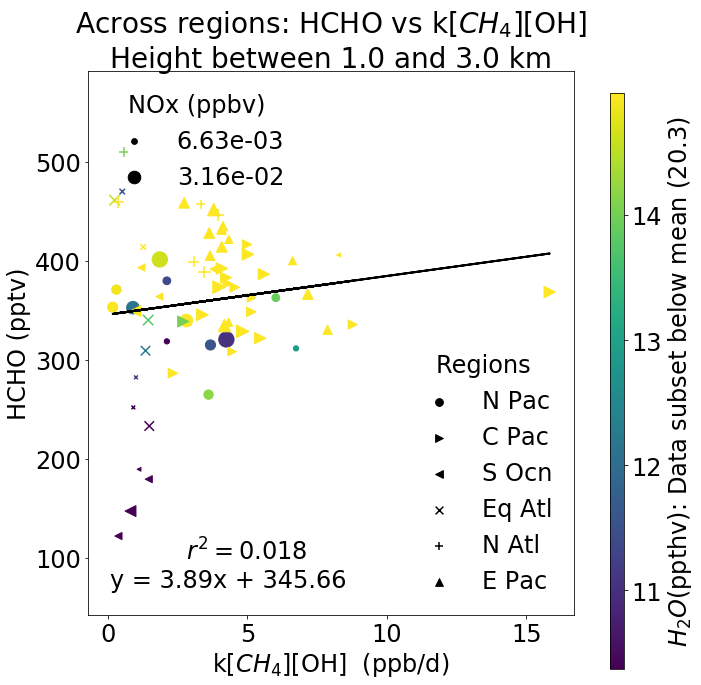

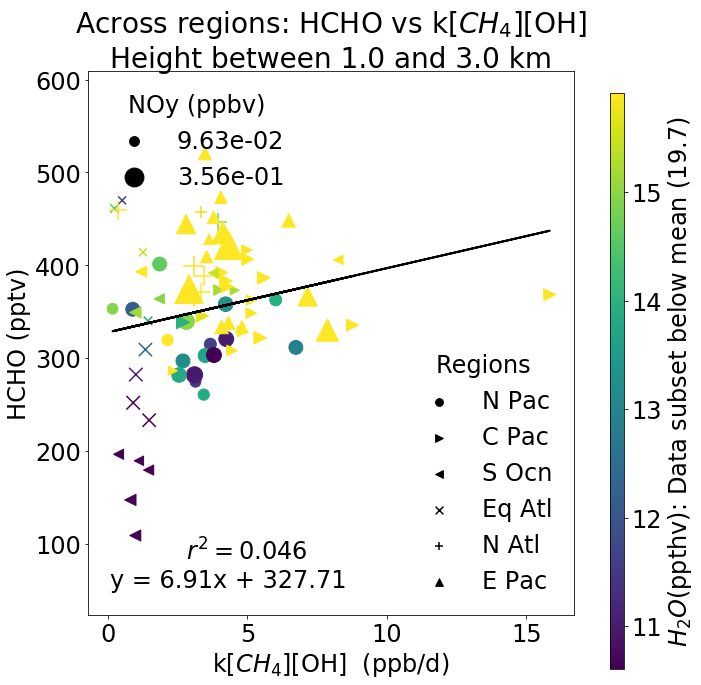

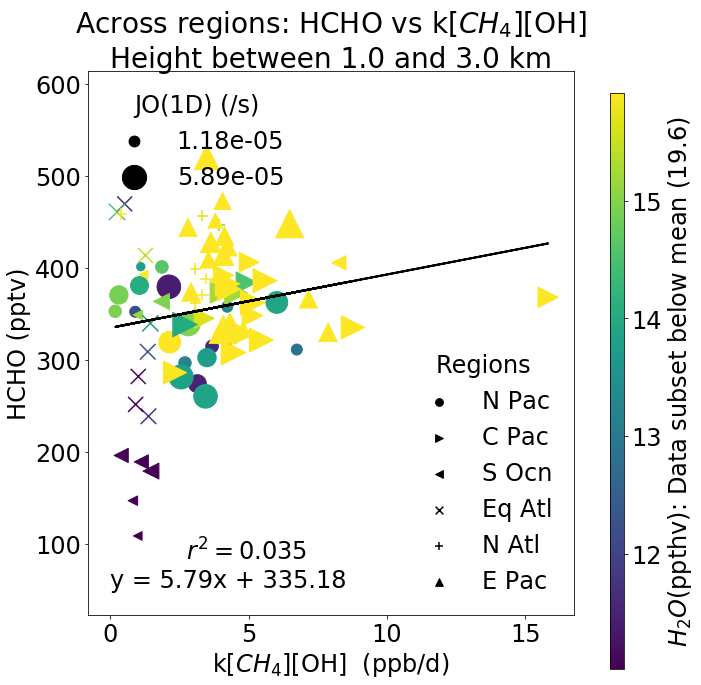

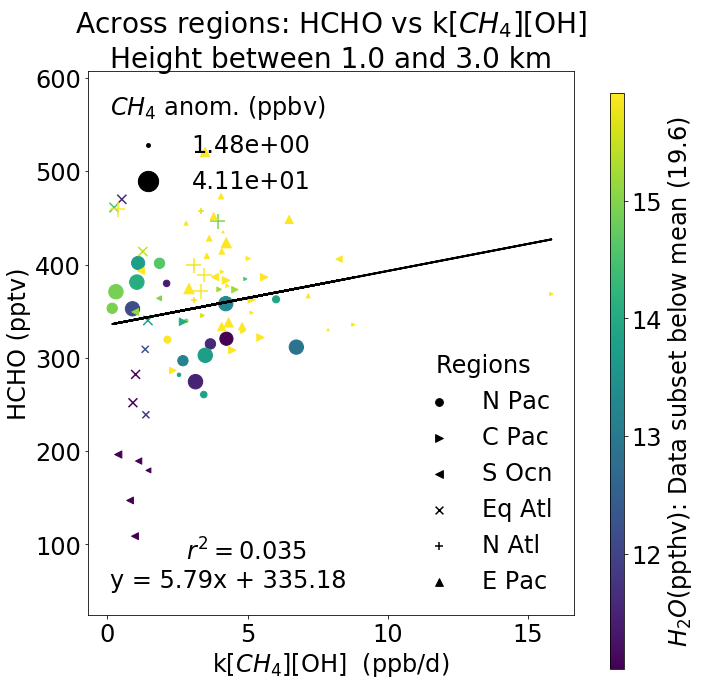

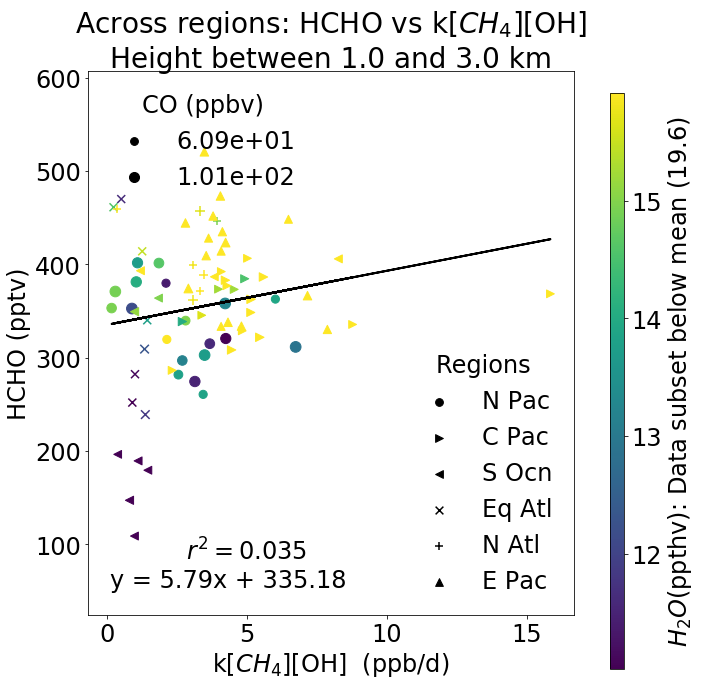

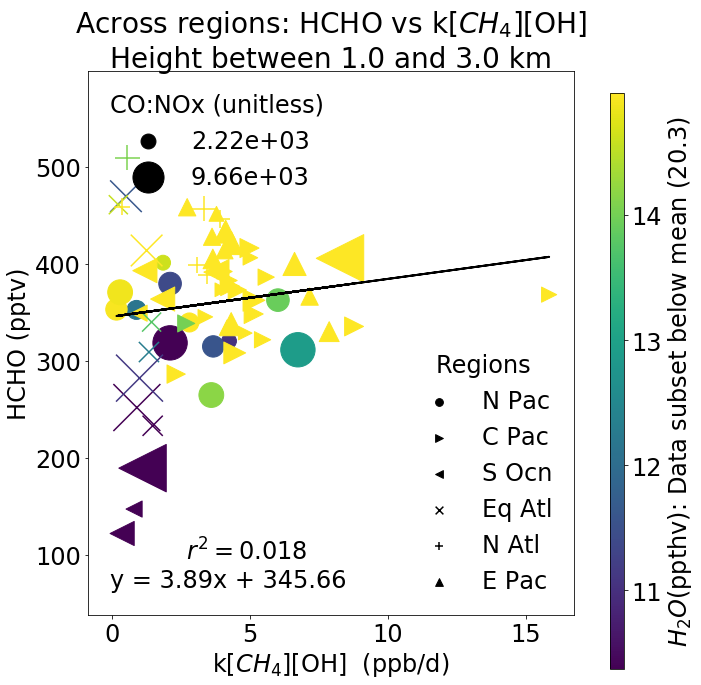

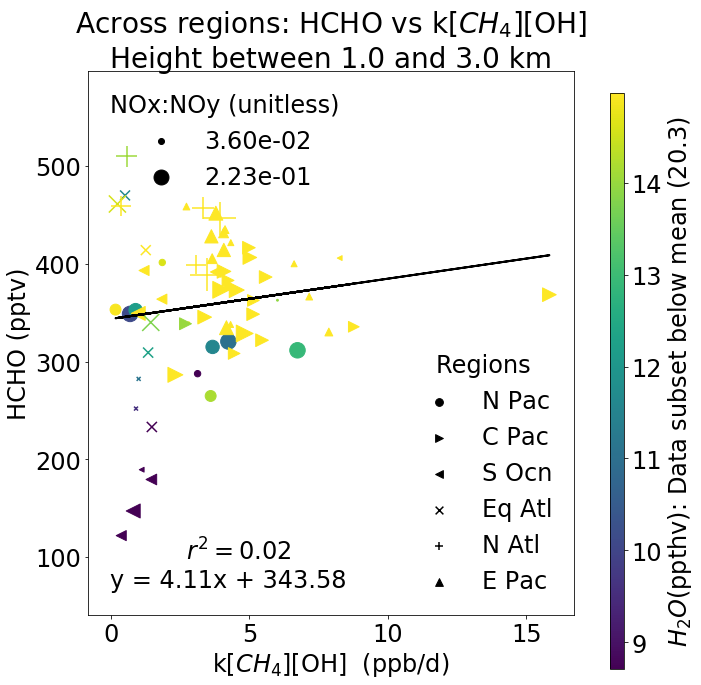

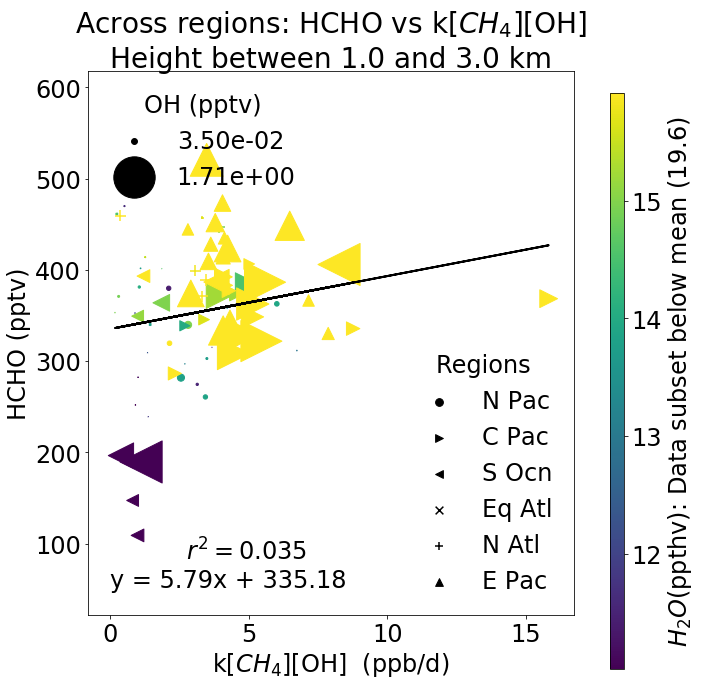

In [18]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'NOx:NOy', 'OH']:
    cor_reg_ht(rg_ttl_loc, 1e3, 3e3, 'HCHO', 'k[$CH_4$][OH]', r'$H_2O$', var, True, False)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var==r'$H_2O$':
        pol='h2o'
    else:
        pol=var
    plt.savefig('Figures/poster 07-17/newreg_071817/corr_1-3km/hcho_kch4oh/' + pol.lower() + '.jpg')

## HCHO vs k[$CH_4$][OH] colored by $H_2O$ between 3 to 6 km

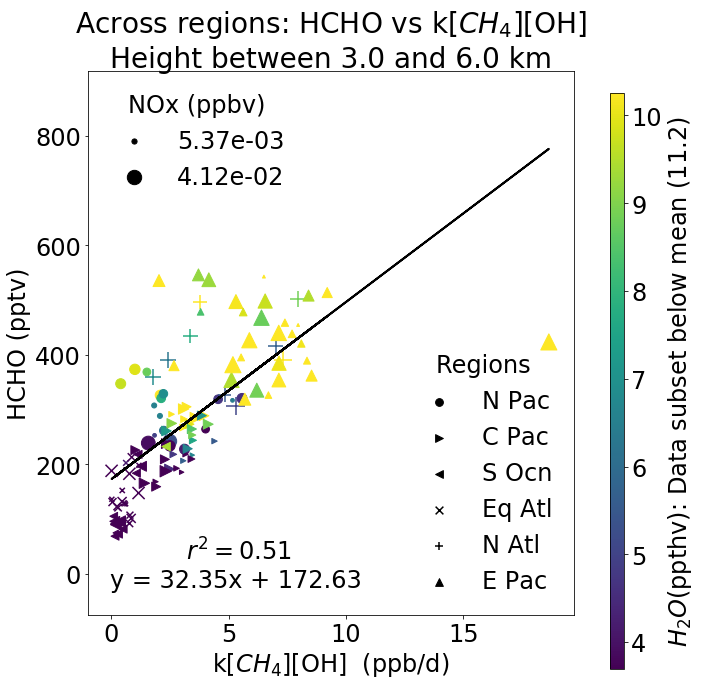

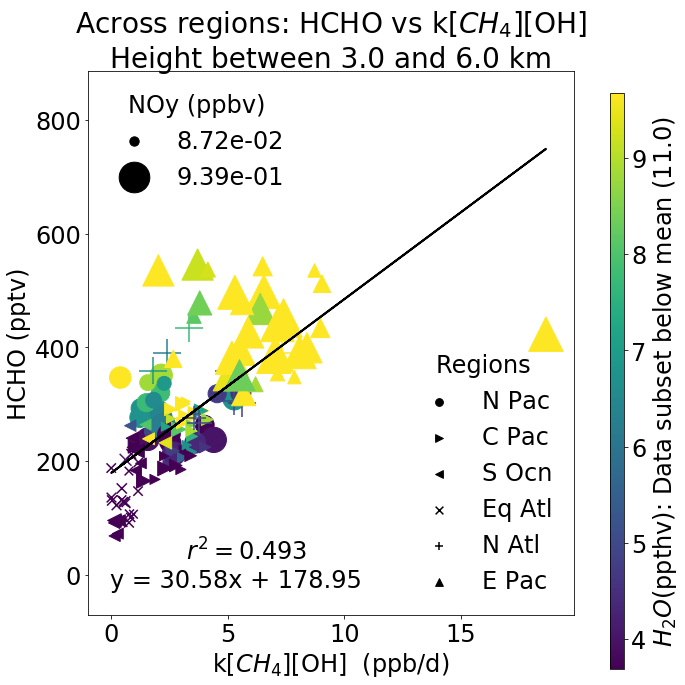

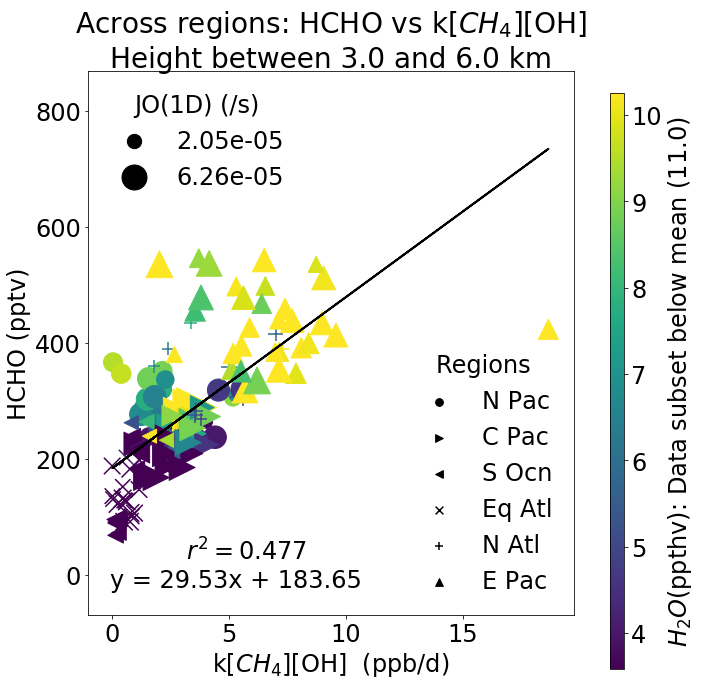

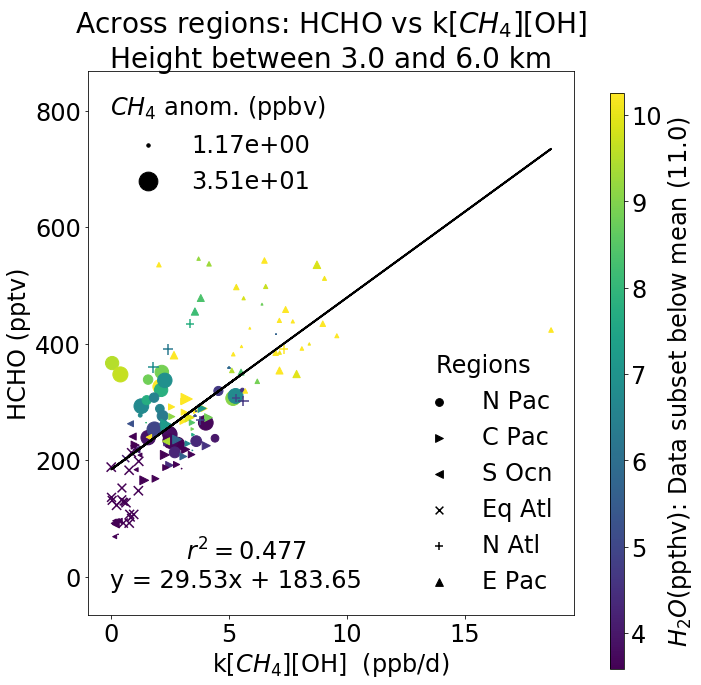

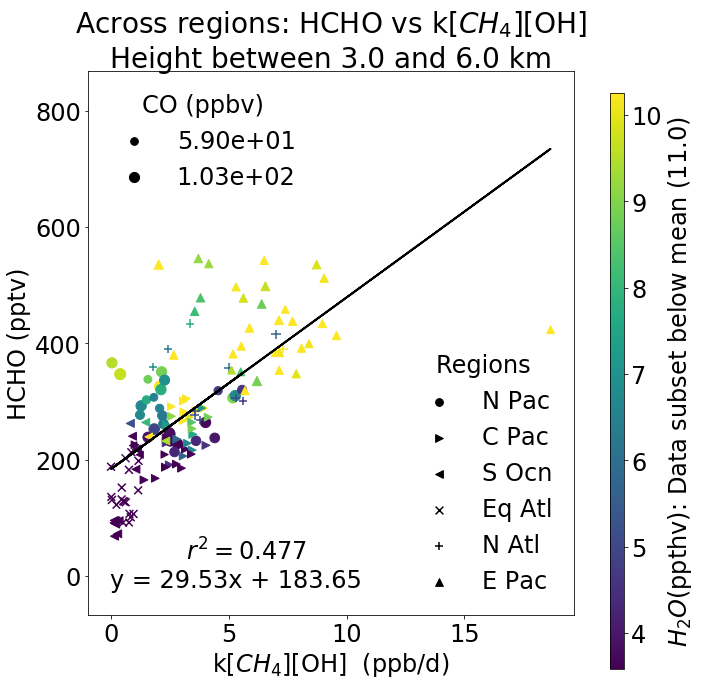

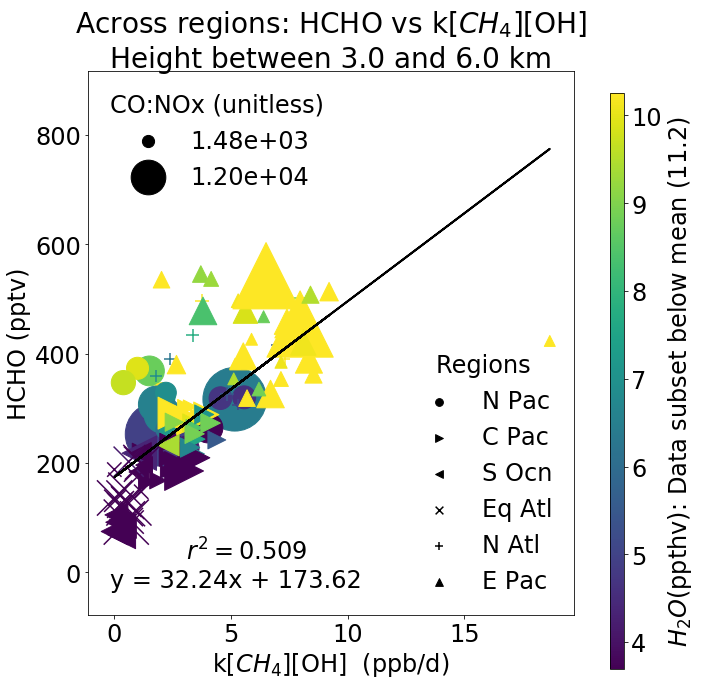

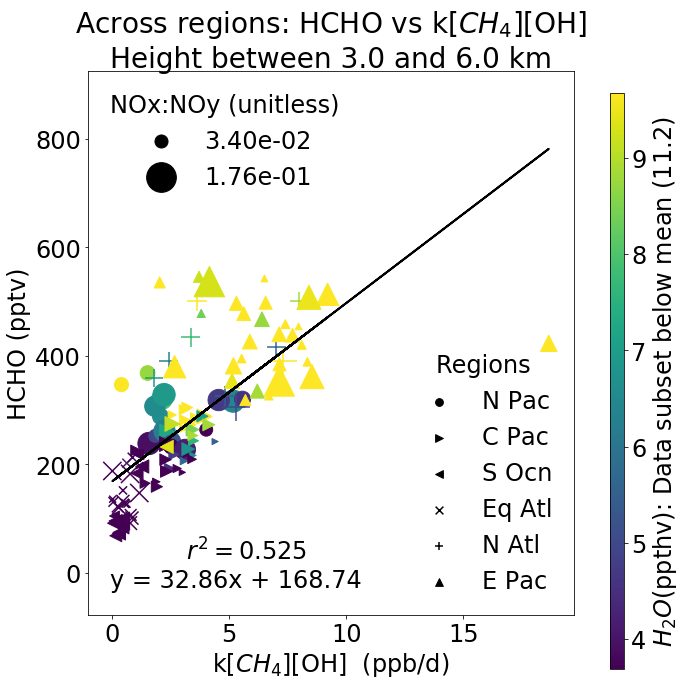

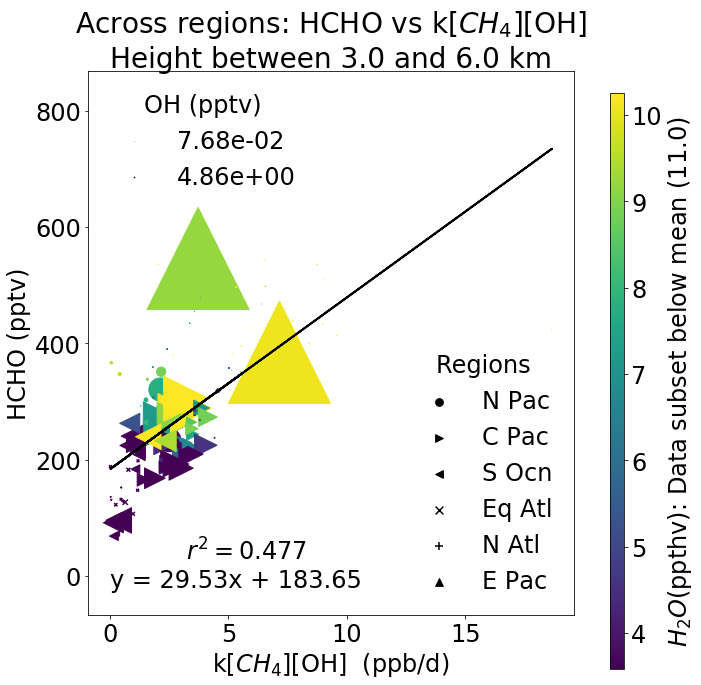

In [19]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'NOx:NOy', 'OH']:
    cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'HCHO', 'k[$CH_4$][OH]', r'$H_2O$', var, True, False)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var==r'$H_2O$':
        pol='h2o'
    else:
        pol=var
    plt.savefig('Figures/poster 07-17/newreg_071817/corr_3-6km/hcho_kch4oh/' + pol.lower() + '.jpg')

## NOx:NOy vs k[$CH_4$][OH]

In [ ]:
for var in ['NOx', 'NOy', 'JO(1D)', r'$CH_4$ anom.', 'CO', 'CO:NOx', 'HCHO', 'OH']:
    cor_reg_ht(rg_ttl_loc, 3e3, 6e3, 'NOx:NOy', 'k[$CH_4$][OH]', r'$H_2O$', var, True, True)
    if var==r'$CH_4$ anom.':
        pol='ch4'
    elif var=='CO:NOx':
        pol='co_nox'
    elif var=='NOx:NOy':
        pol='nox_noy'
    elif var==r'$H_2O$':
        pol='h2o'
    else:
        pol=var
    plt.savefig('Figures/poster 07-17/newreg_071817/corr_3-6km/noxnoy_kch4oh/log/' + pol.lower() + '.jpg')